# Lab Three: Option B#

* Billy Nayden
* Sean McWhirter
* Andrew Mejia
* Rajesh Salturi

In [496]:
import plotly
plotly.offline.init_notebook_mode()
import pandas as pd
import numpy as np 
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from pandas.plotting import boxplot
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, mean_squared_error, median_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.model_selection import FeatureImportances
from sklearn.cluster import AgglomerativeClustering



print(__doc__)


Automatically created module for IPython interactive environment


##### Regression Analysis Helper Functions

In [445]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)


def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
med_scorer = make_scorer(score_func=median_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
mse_scorer = make_scorer(score_func = mean_squared_error, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer, 
                'MSE' : mse_scorer,
                'MED' : med_scorer
               } 

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1
    scores['test_MSE'] = scores['test_MSE'] * -1
    scores['score_time'] = scores['score_time']
    scores['test_MED'] = scores['test_MED'] * -1
    
    

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))
    
    #print mean MED for all folds 
    med = np.median(scores['test_MED'])
    print_str = "The median absolute error for all cv folds is: \t\t\t {med:.5}"
    print(print_str.format(med=med))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')
    
    #print mean MAE for all folds 
    MSEavg = scores['test_MSE'].mean()
    print_str = "The average MSE for all cv folds is: \t\t\t {MSEavg:.5}"
    print(print_str.format(MSEavg=MSEavg))
    print('*********************************************************')
    
    
    Mst = scores['score_time'].mean()
    print_str = "The average score_time for all cv folds is: \t\t\t {Mst:.5}"
    print(print_str.format(Mst=Mst))
    print('*********************************************************')


    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MED'] = scores['test_MED']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['MSE'] = scores['test_MSE']
    scoresResults['SCORE_TIME'] = scores['score_time']
    
    return scoresResults

#This basic linear regression is capped at the dynamic range of the data set and it is capped to the dynamic range of the data
#1e0 to 2.2e9
class CappedLinearRegression(LinearRegression):
    

    def predict(self, X):
        
        
        return np.clip(super(CappedLinearRegression, self).predict(X), 0.0e0,2.21e9) 
    
    
#This basic linear regression is capped at the dynamic range of the data set and it is capped to the dynamic range of the base 10 log data
#0e0 to 2.1e1
    
class CappedLogLinearRegression(LinearRegression):
    

    def predict(self, X):
        
        
        return np.clip(super(CappedLogLinearRegression, self).predict(X), 0.0e0,2.1e1) 

##### Other Helper Functions

In [402]:
def remove_white_space(cols_list, dataframe): 
    df = dataframe
    for col in cols_list:
        df[col] = df[col].str.strip()
    return df 
    
    
def unique_categories(columns_list, dataframe_1): 
    miss_cat_vars = {}
    for var in columns_list: 
        print(var)
        k,v = var,dataframe_1[var].unique()
        miss_cat_vars.update({k : v})
    return miss_cat_vars

#Adapted from Jezreal's answer 
#https://stackoverflow.com/questions/51189962/how-to-replace-0-values-with-mean-based-on-groupby

def grouper_impute(dataframe_2, grouper_col = None, grouper_impute = None, replace_val = None, transfrmtn = None): 

    dataframe_2[grouper_impute] = dataframe_2[grouper_impute].replace(replace_val, np.nan)
    dataframe_2[grouper_impute] = dataframe_2[grouper_impute].fillna(dataframe_2.groupby(grouper_col)[grouper_impute].transform(transfrmtn))
    return dataframe_2


# This function creates dummy encodings from a lsit of features of interest and returns a dataframe     
def create_dummy_encod(ml_df,features_of_interest, drop_first_cat=True, sparsity=True): 
    tmp_cont = []
    ml_data_copy = ml_df.copy()
    for feat in features_of_interest: 
        tmp_df = pd.get_dummies(ml_data_copy[feat],prefix=str(feat),sparse=sparsity,drop_first=drop_first_cat)
        tmp_cont.append(tmp_df)
        feat_df = pd.concat(tmp_cont,axis=1)
        ml_df = pd.concat([ml_data_copy,feat_df], axis=1)
        ml_df = ml_df.drop(columns = features_of_interest, axis = 1)
    return ml_df 


# Data Understanding 1

# Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems? # 

The data set we will be working with is the NYC property data sales from New York City for the 5 boroughs.

https://www.kaggle.com/new-york-city/nyc-property-sales

We want to create a regressor to predict a property's SALE PRICE, for the entire dynamic range of values from the data set. Recall the dynamic range is from 1e0 to 2.2e9. 

This dataset contains the location, address, type, sale price, and sale date of building units sold. A reference on the trickier fields:

BOROUGH: A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

BLOCK; LOT: The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a BBL. We will not use this combination in our analysis, as we will treat Block and Lot as independent features, since it is a nominal label created using this type of key value pair. Rather, we will engineer a feature using BOROUGH and ZIPCODE to proxy a similar result for our clustering analysis. 
https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm


BUILDING CLASS AT PRESENT and BUILDING CLASS AT TIME OF SALE: The type of building at various points in time. See the glossary linked to below.

Note that because this is a financial transaction dataset, there are some points that need to be kept in mind:

There are sales with a $0 dollar value. These sales are actually transfers of deeds between parties: for example, parents transferring ownership of their home to a child after moving out for retirement. There are also dollar values of '-', which we are not sure what these are, as there is no clear definition in the documentation. 

For the later part of the experiment. 

# Reading in and previewing the data 

In [403]:
raw_data_url = 'https://raw.githubusercontent.com/andrewmejia600/MSDS7331/master/RAW_DATA/nyc-rolling-sales.csv'
#raw_data_url = '/media/andrew/29426984-e707-487c-8f66-ca5e368b23d12/Documents/School/HomeWork/ML_1/TEAM_GH/MSDS7331/RAW_DATA/nyc-rolling-sales.csv'

In [404]:
raw_data = pd.read_csv(raw_data_url, encoding="utf-8", converters = {'LAND SQUARE FEET': str.strip, 'GROSS SQUARE FEET' : str.strip, 'SALE PRICE': str.strip  } )
raw_data.head(n=5)

Unnamed: 0  BOROUGH   NEIGHBORHOOD  \
0           4        1  ALPHABET CITY   
1           5        1  ALPHABET CITY   
2           6        1  ALPHABET CITY   
3           7        1  ALPHABET CITY   
4           8        1  ALPHABET CITY   

                       BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  \
0  07 RENTALS - WALKUP APARTMENTS                                2A    392   
1  07 RENTALS - WALKUP APARTMENTS                                 2    399   
2  07 RENTALS - WALKUP APARTMENTS                                 2    399   
3  07 RENTALS - WALKUP APARTMENTS                                2B    402   
4  07 RENTALS - WALKUP APARTMENTS                                2A    404   

   LOT EASE-MENT BUILDING CLASS AT PRESENT                 ADDRESS  ...  \
0    6                                  C2            153 AVENUE B  ...   
1   26                                  C7   234 EAST 4TH   STREET  ...   
2   39                                  C7   197 EAST 3RD   STREET  ...   
3   21                                  C4     154 EAST 7TH STREET  ...   
4   55                                  C2  301 EAST 10TH   STREET  ...   

  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  \
0                 5                 0            5              1633   
1                28                 3           31              4616   
2                16                 1           17              2212   
3                10                 0           10              2272   
4                 6                 0            6              2369   

   GROSS SQUARE FEET YEAR BUILT TAX CLASS AT TIME OF SALE  \
0               6440       1900                         2   
1              18690       1900                         2   
2               7803       1900                         2   
3               6794       1913                         2   
4               4615       1900                         2   

   BUILDING CLASS AT TIME OF SALE  SALE PRICE            SALE DATE  
0                              C2     6625000  2017-07-19 00:00:00  
1                              C7           -  2016-12-14 00:00:00  
2                              C7           -  2016-12-09 00:00:00  
3                              C4     3936272  2016-09-23 00:00:00  
4                              C2     8000000  2016-11-17 00:00:00  

[5 rows x 22 columns]

In [405]:
raw_data.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

# Data Meaning

The raw data attribute explanations are as follows:

Unnamed: 0 - An index from the data source that is not defined

BOROUGH - A nominal digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

NEIGHBOHOOD - The neighboorhood of the address, a nominal value

BUILDING CLASS CATEGORY - Is the description of the building class, reference, a nominal value 
https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html

TAX CLASS AT PRESENT - The Tax class of the building at the time when the data was collected, a nominal value

BLOCK - The physical block of the address, a nominal value 

LOT - The lot on the the block, a nominal value 

EASE-MENT - A sparse column with no values in it, just white space.

BUILDING CLASS AT PRESENT - The building class at the time of data collection, a nominal value 

ADDRESS - The Physical address of the building, a nominal value 

APARTMENT NUMBER - The Apartment Number of the unit, a nominal value 

ZIP CODE - Zip Code of the property, a nominal value

RESIDENTIAL UNITS - The number of residential units to the building, an integer value 

COMMERCIAL UNITS - The number of commerifal units to the building, an integer value 

TOTAL UNITS - The number of total units, the sum of Residential and Commercial Units to the building, an integer value 

LAND SQUARE FEET - The physical foot print of square feet of the building, an integer value 

GROSS SQUARE FEET - The entire square footage of the buidling, the sum of the floor square footage for mutli-story buildings, an integer value 

YEAR BUILT - The year of construction of the property, an ordinal value 

TAX CLASS AT TIME OF SALE - The tax class of the building when the property sold, a nominal value 

BUILDING CLASS AT TIME OF SALE - The building class at the time when the property sold, a nominal value 

SALE PRICE - The sale price of the building, $0 are indicative of family property transfers and '-' are where there is no known sale price, an integer value 

SALE DATE - The sale date of the property, an ordinal value

In [406]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

In [407]:
housing_data = raw_data.copy()

We see there are potentially 22 features for us to use for the regression task of the data. We will drop the **Unamed 0:** column as it appears to be an index that is not of importance. 

**EASE-MENT** is another feature that is mostly sparse, and shows no real value as a feature. 

Address has many nominal values and will not serve as a sound predictor, and will drastically increase the number of features to be encoded, so we will drop this column as well.  

Therefore the further analysis and model testing will be conducted without Unamed:0, EASE-MENT, and Address. We will also replace **SALE DATE** with **DATEOFSALE** as **DATEOFSALE** will be used for downline processing and will be in date time format. 

In [408]:
housing_data['DATEOFSALE'] = pd.to_datetime(housing_data['SALE DATE'])

In [409]:
housing_data = housing_data.drop(columns = ['Unnamed: 0', 'EASE-MENT', 'APARTMENT NUMBER', 'SALE DATE'], axis = 1)

# Data Quality 

We are removing the whitespace from the column names to make them easier to manipulate in our modeling analysis and building.

In [410]:
housing_data.columns = housing_data.columns.str.replace(' ', '')

We are removing the whitespace from the column values to make them easier to manipulate in our modeling analysis and building.

In [411]:
catagorical_vars = list(housing_data.select_dtypes(include='object').columns)
print(catagorical_vars)

['NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'TAXCLASSATPRESENT', 'BUILDINGCLASSATPRESENT', 'ADDRESS', 'LANDSQUAREFEET', 'GROSSSQUAREFEET', 'BUILDINGCLASSATTIMEOFSALE', 'SALEPRICE']


In [412]:
housing_data = remove_white_space(catagorical_vars, housing_data)

We take a copy of the housing_data since we will be imputing the $0 dollar values based on the zip code median for further clustering analysis 

In [413]:
housing_data_imputed = housing_data.copy() 

In [414]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   BOROUGH                    84548 non-null  int64         
 1   NEIGHBORHOOD               84548 non-null  object        
 2   BUILDINGCLASSCATEGORY      84548 non-null  object        
 3   TAXCLASSATPRESENT          84548 non-null  object        
 4   BLOCK                      84548 non-null  int64         
 5   LOT                        84548 non-null  int64         
 6   BUILDINGCLASSATPRESENT     84548 non-null  object        
 7   ADDRESS                    84548 non-null  object        
 8   ZIPCODE                    84548 non-null  int64         
 9   RESIDENTIALUNITS           84548 non-null  int64         
 10  COMMERCIALUNITS            84548 non-null  int64         
 11  TOTALUNITS                 84548 non-null  int64         
 12  LAND

In [415]:
housing_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   BOROUGH                    84548 non-null  int64         
 1   NEIGHBORHOOD               84548 non-null  object        
 2   BUILDINGCLASSCATEGORY      84548 non-null  object        
 3   TAXCLASSATPRESENT          84548 non-null  object        
 4   BLOCK                      84548 non-null  int64         
 5   LOT                        84548 non-null  int64         
 6   BUILDINGCLASSATPRESENT     84548 non-null  object        
 7   ADDRESS                    84548 non-null  object        
 8   ZIPCODE                    84548 non-null  int64         
 9   RESIDENTIALUNITS           84548 non-null  int64         
 10  COMMERCIALUNITS            84548 non-null  int64         
 11  TOTALUNITS                 84548 non-null  int64         
 12  LAND

As we are not sure what the '-' value for sale price means, we will omit it from further analysis, as these could be family property transfers or transfers other than sales where there is not a $0 value or there is no other data known for this observation. We see there are 14561 observations of this type. It must be stated, for future generalizations, the outcomes of these regression models for both the housing_data and housing_data_imputed are limited to observations that do not fall into this category. 

In [416]:
len(housing_data[housing_data['SALEPRICE'] == '-']) 

14561

We see this is also the case with **LANDSQUAREFEET** and **GROSSSQUAREFEET** as well and we see there are instances where there is a 0 **Zipcode**. As there is no way to vet what the true zip code of the property would be, without extensive searching, we will exclude these observations from our initial analysis, but we will impute the zero values with the zipcode medians in the imputed dataframe, **housing_data_imputed**, only. We also see there are some properties with a 0 total units, so we will exclude these observations from our initial clustering data set, housing_data, as we do not want to artifically inflate the number of total units by adding to the column. With these exclusions, we must restate our previous disclaimer of the outcomes of these regression models are limited to observations that do not fall into this category.

In [417]:
len(housing_data[((housing_data['LANDSQUAREFEET'] == '-') | (housing_data['GROSSSQUAREFEET'] == '-') | (housing_data['SALEPRICE'] == '-'))])

36304

In [418]:
housing_data = housing_data[~((housing_data['LANDSQUAREFEET'] == '-') | (housing_data['GROSSSQUAREFEET'] == '-') | (housing_data['SALEPRICE'] == '-'))]

housing_data_imputed = housing_data_imputed[~((housing_data_imputed['LANDSQUAREFEET'] == '-') | (housing_data_imputed['GROSSSQUAREFEET'] == '-') | (housing_data_imputed['SALEPRICE'] == '-'))]

In [419]:
housing_data = housing_data[(housing_data['ZIPCODE'] != 0) & (housing_data['TOTALUNITS'] != 0)
                           & (housing_data['SALEPRICE'] != 0) & (housing_data['YEARBUILT'] != 0)
                           & (housing_data['LANDSQUAREFEET'] != 0) & (housing_data['GROSSSQUAREFEET'] != 0)] 

Resetting the index to the data

In [420]:
housing_data = housing_data.reset_index(drop=True)

In [421]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41411 entries, 0 to 41410
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   BOROUGH                    41411 non-null  int64         
 1   NEIGHBORHOOD               41411 non-null  object        
 2   BUILDINGCLASSCATEGORY      41411 non-null  object        
 3   TAXCLASSATPRESENT          41411 non-null  object        
 4   BLOCK                      41411 non-null  int64         
 5   LOT                        41411 non-null  int64         
 6   BUILDINGCLASSATPRESENT     41411 non-null  object        
 7   ADDRESS                    41411 non-null  object        
 8   ZIPCODE                    41411 non-null  int64         
 9   RESIDENTIALUNITS           41411 non-null  int64         
 10  COMMERCIALUNITS            41411 non-null  int64         
 11  TOTALUNITS                 41411 non-null  int64         
 12  LAND

In [422]:
housing_data_imputed = housing_data_imputed.reset_index(drop=True)

In [423]:
housing_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48244 entries, 0 to 48243
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   BOROUGH                    48244 non-null  int64         
 1   NEIGHBORHOOD               48244 non-null  object        
 2   BUILDINGCLASSCATEGORY      48244 non-null  object        
 3   TAXCLASSATPRESENT          48244 non-null  object        
 4   BLOCK                      48244 non-null  int64         
 5   LOT                        48244 non-null  int64         
 6   BUILDINGCLASSATPRESENT     48244 non-null  object        
 7   ADDRESS                    48244 non-null  object        
 8   ZIPCODE                    48244 non-null  int64         
 9   RESIDENTIALUNITS           48244 non-null  int64         
 10  COMMERCIALUNITS            48244 non-null  int64         
 11  TOTALUNITS                 48244 non-null  int64         
 12  LAND

We wanted to create a copy of the sale price for use with our imputations for the regression of sale price and to perserve the original sale price as we will be performing group imputations based on the median zipcode later in the notebook. 

In [424]:
housing_data_imputed['SALEPRICECPY'] = housing_data_imputed['SALEPRICE']


We see some attributes, such as **LANDSQUREFEET**, **GROSSSUAREFEET** and **SALEPRICE** are the wrong data type. 
We are changing the data types to **SALEPRICE**, **LANDSQUAREFEET** and **GROSSSQUAREFEET** to int64, and making **ZIPCODE** a nominal label, as **ZIPCODE** is more of a nominal label in this case rather than an ordinal value, since a higher **ZIPCODE** number does not necessiarily correspond to a more favorable property.

In [425]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html
housing_data = housing_data.astype({'SALEPRICE': 'int64', 'LANDSQUAREFEET' : 'int64', 'GROSSSQUAREFEET' : 'int64', 'ZIPCODE' : 'object'})

housing_data_imputed = housing_data_imputed.astype({'SALEPRICE': 'int64', 'SALEPRICECPY': 'int64', 'LANDSQUAREFEET' : 'int64', 'GROSSSQUAREFEET' : 'int64', 'ZIPCODE' : 'object'})

We shall impute the $0 **SALEPRICE** feature, that are family transfers, with the median saleprice of the **ZIPCODE**. As we are assuming these values should be relatively close to each other if they are within the zip code, since using **BOROUGH** could be too general. 

We will impute **YEARBUILT**, **LANDSQUAREFEET** and **GROSSSQUREFEET** with the median of the **ZIPCODE** as well for similar reasons. 

This is only for the imputed dataframe, **housing_data_imputed** only


In [426]:
housing_data_imputed = grouper_impute(dataframe_2 = housing_data_imputed, grouper_col = 'ZIPCODE', grouper_impute = 'SALEPRICE', replace_val = 0, transfrmtn = 'median')

housing_data_imputed = grouper_impute(dataframe_2 = housing_data_imputed, grouper_col = 'ZIPCODE', grouper_impute = 'YEARBUILT', replace_val = 0, transfrmtn = 'median')


housing_data_imputed = grouper_impute(dataframe_2 = housing_data_imputed, grouper_col = 'ZIPCODE', grouper_impute = 'LANDSQUAREFEET', replace_val = 0, transfrmtn = 'median')

housing_data_imputed = grouper_impute(dataframe_2 = housing_data_imputed, grouper_col = 'ZIPCODE', grouper_impute = 'GROSSSQUAREFEET', replace_val = 0, transfrmtn = 'median')

In [427]:
housing_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48244 entries, 0 to 48243
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   BOROUGH                    48244 non-null  int64         
 1   NEIGHBORHOOD               48244 non-null  object        
 2   BUILDINGCLASSCATEGORY      48244 non-null  object        
 3   TAXCLASSATPRESENT          48244 non-null  object        
 4   BLOCK                      48244 non-null  int64         
 5   LOT                        48244 non-null  int64         
 6   BUILDINGCLASSATPRESENT     48244 non-null  object        
 7   ADDRESS                    48244 non-null  object        
 8   ZIPCODE                    48244 non-null  object        
 9   RESIDENTIALUNITS           48244 non-null  int64         
 10  COMMERCIALUNITS            48244 non-null  int64         
 11  TOTALUNITS                 48244 non-null  int64         
 12  LAND

In [428]:
housing_data_imputed.describe()

BOROUGH         BLOCK           LOT  RESIDENTIALUNITS  \
count  48244.000000  48244.000000  48244.000000      48244.000000   
mean       3.251741   4984.532191    234.324662          2.566537   
std        0.903136   3427.418090    496.361521         17.465481   
min        1.000000      1.000000      1.000000          0.000000   
25%        3.000000   2206.750000     21.000000          1.000000   
50%        3.000000   4660.500000     45.000000          1.000000   
75%        4.000000   6996.000000     94.000000          2.000000   
max        5.000000  16319.000000   9009.000000       1844.000000   

       COMMERCIALUNITS    TOTALUNITS  LANDSQUAREFEET  GROSSSQUAREFEET  \
count     48244.000000  48244.000000    4.824400e+04     4.824400e+04   
mean          0.249171      2.834632    3.864491e+03     4.365970e+03   
std          10.988072     20.750418    3.139752e+04     2.941921e+04   
min           0.000000      0.000000    2.000000e+00     6.000000e+01   
25%           0.000000      1.000000    2.000000e+03     1.590000e+03   
50%           0.000000      1.000000    2.458000e+03     2.208000e+03   
75%           0.000000      2.000000    3.145000e+03     3.000000e+03   
max        2261.000000   2261.000000    4.228300e+06     3.750565e+06   

          YEARBUILT  TAXCLASSATTIMEOFSALE     SALEPRICE  SALEPRICECPY  
count  48244.000000          48244.000000  4.824400e+04  4.824400e+04  
mean    1944.944086              1.475769  1.309274e+06  1.153281e+06  
std       33.733054              0.833589  1.339195e+07  1.340131e+07  
min     1800.000000              1.000000  1.000000e+00  0.000000e+00  
25%     1920.000000              1.000000  4.250000e+05  8.042000e+04  
50%     1931.000000              1.000000  6.225000e+05  4.800000e+05  
75%     1963.000000              2.000000  9.550000e+05  8.300000e+05  
max     2017.000000              4.000000  2.210000e+09  2.210000e+09

#### ENGINEERED FEATURES

We are creating an ordinal feature for when in the month the property sold, 1 being the first of the month, 2 being the middle of the month and 3 being the last of the month. 

In [429]:
string_of_day = housing_data.DATEOFSALE.astype(str).str.slice(start=-2).astype(int)

housing_data['TIMEOFMONTH'] = pd.cut(string_of_day, [1,14,15,31], labels=[1,2,3], include_lowest=True)
housing_data_imputed['TIMEOFMONTH'] = pd.cut(string_of_day, [1,14,15,31], labels=[1,2,3], include_lowest=True)

In [430]:
housing_data.TIMEOFMONTH = housing_data.TIMEOFMONTH.astype(object)

housing_data_imputed.TIMEOFMONTH = housing_data.TIMEOFMONTH.astype(object)

When reviewing https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html the New York Building class at present feature has many nominal features. We wanted a more general feature of what the building type is, i.e. whether the property is a multi family dwelling with vs  with out an elevator. 

* `DWELLING` -- Dwelling
* `MULTI_DWELLING_NO_ELV`-- Multifamily dwelling no elevator 
* `MULTI_DWELLING_ELV` -- Multifamily dwelling with elevator
* `WAREHOUSE` -- Warehouse
* `FACTORY` -- Factory
* `GARAGE_P_LOT` -- Garage or Parking Lot
* `HOTEL` -- Hotel 
* `HOSIPTAL` -- Hospital 
* `THEATRE` -- Theatre
* `RETAIL` -- Retail 
* `LOFT` -- Loft 
* `RELIGIOUS` -- Religious 
* `SOCIAL_INSTITUTION` -- Social Institution, i.e. an Asylum 
* `OFFICE` -- Office 
* `COMMUNITY_CENTER` -- Community Center
* `PUBLIC_REC` -- Public Recreation
* `COMMERCIAL` -- Commercial 
* `DWELLING_RETAIL` -- Dwelling with retail 
* `PORT` -- Port of entry 
* `UTILITY` -- Utility, i.e. railroad 
* `ZONED` -- Zoned, i.e. Courthouse
* `SCHOOL` -- Schools 
* `PUBLIC_SAFETY` -- Public Safety, i.e. Firehouse 
* `OTHER` -- Catch all

In [431]:
#https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html#A
BUILD_CLASS_DICT_ = {'A' : 'DWELLING', 'B' : 'DWELLING', 'C' : 'MULTI_DWELLING_NO_ELV', 'D' : 'MULTI_DWELLING_ELV', 'E' : 'WAREHOUSE', 'F' : 'FACTORY', 'G' : 'GARAGE_P_LOT', 'H' : 'HOTEL', 'I' : 'HOSIPTAL', 'J' : 'THEATRE', 'K' : 'REATAIL', 'L' : 'LOFT', 'M' : 'RELIGIOUS', 'N' : 'SOCIAL_INSTITUTION', 'O' : 'OFFICE', 'P' : 'COMMUNITY_CENTER', 'Q' : 'PUBLIC_REC', 'R' : 'COMMERCIAL' , 'S' : 'DWELLING_RETAIL', 'T' : 'PORT', 'U' : 'UTILITY', 'V' : 'ZONED', 'W' : 'SCHOOL', 'Y' : 'PUBLIC_SAFETY', 'Z' : 'OTHER'}

housing_data['BUILDCLASSGENER'] = housing_data.BUILDINGCLASSATPRESENT.astype(str).str.slice(start=0, stop=1).map(BUILD_CLASS_DICT_)

housing_data_imputed['BUILDCLASSGENER'] = housing_data_imputed.BUILDINGCLASSATPRESENT.astype(str).str.slice(start=0, stop=1).map(BUILD_CLASS_DICT_)


We will engineer a feature for the decade of when the property was built. 

In [432]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.pad.html
housing_data['DECADEBUILT'] = housing_data.YEARBUILT.astype(str).str.slice(start=0,stop=3).str.pad(width = 4, side='right', fillchar = str(0))

housing_data_imputed['DECADEBUILT'] = housing_data_imputed.YEARBUILT.astype(str).str.slice(start=0,stop=3).str.pad(width = 4, side='right', fillchar = str(0))

We will engineer a feature for the age of the property at time of sale, by subtracting the date of sale year from the year built. 

In [433]:
housing_data['BUILDAGE'] = housing_data.DATEOFSALE.astype(str).str.slice(start=0,stop=4).astype(int) - housing_data.YEARBUILT

housing_data_imputed['BUILDAGE'] = housing_data_imputed.DATEOFSALE.astype(str).str.slice(start=0,stop=4).astype(int) - housing_data_imputed.YEARBUILT

## Additional feature engineering for clustering

We will be performing clustering on some features, so we will be engineering a feature that seems to make sense fot total number of units.We will add together Residential and Commerical Units and call it **RES_COM_UNITS**. 

In [434]:
housing_data['RES_COM_UNITS'] = housing_data.RESIDENTIALUNITS + housing_data.COMMERCIALUNITS

housing_data_imputed['RES_COM_UNITS'] = housing_data_imputed.RESIDENTIALUNITS + housing_data_imputed.COMMERCIALUNITS

We will create an additional feature for clustering, **BorZip**, where we will add **BOROUGH** to the end of **ZIPCODE** as a unique identifier as described by the data definition, similar to the original **BBL** mentioned in the data defintion section. We are doing this since we want a unique identifier to use as part of our clustering data reduction analysis. There are 5 unique Boroughs and 177 unique zipcodes, this will give us enough additional dimensions for our features for the clustering analysis, if we used the **BBL**, this would create over 10,000 additional dimensions, which is not practical for feature clustering. 

In [435]:
housing_data.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'TAXCLASSATPRESENT',
       'BLOCK', 'LOT', 'BUILDINGCLASSATPRESENT', 'ADDRESS', 'ZIPCODE',
       'RESIDENTIALUNITS', 'COMMERCIALUNITS', 'TOTALUNITS', 'LANDSQUAREFEET',
       'GROSSSQUAREFEET', 'YEARBUILT', 'TAXCLASSATTIMEOFSALE',
       'BUILDINGCLASSATTIMEOFSALE', 'SALEPRICE', 'DATEOFSALE', 'TIMEOFMONTH',
       'BUILDCLASSGENER', 'DECADEBUILT', 'BUILDAGE', 'RES_COM_UNITS'],
      dtype='object')

In [436]:
#housing_data['BorZip'] = housing_data.BOROUGH.map() + housing_data.ZIPCODE.astype('int64')
housing_data['BorZip'] = housing_data.BOROUGH.map(str) + housing_data.ZIPCODE.map(str)
housing_data = housing_data.astype({'BorZip': 'int64'})
housing_data.head()
#+ housing_data.LOT

#housing_data_imputed['BorZip'] = housing_data_imputed.BOROUGH + housing_data_imputed.ZIPCODE.astype('int64')
housing_data_imputed['BorZip'] = housing_data_imputed.BOROUGH.map(str) + housing_data_imputed.ZIPCODE.map(str)
housing_data_imputed = housing_data_imputed.astype({'BorZip': 'int64'})
housing_data_imputed.head()
#+ housing_data_imputed.LOT

BOROUGH   NEIGHBORHOOD             BUILDINGCLASSCATEGORY TAXCLASSATPRESENT  \
0        1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS                2A   
1        1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS                2B   
2        1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS                2A   
3        1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS                2B   
4        1  ALPHABET CITY  08 RENTALS - ELEVATOR APARTMENTS                 2   

   BLOCK  LOT BUILDINGCLASSATPRESENT                 ADDRESS ZIPCODE  \
0    392    6                     C2            153 AVENUE B   10009   
1    402   21                     C4     154 EAST 7TH STREET   10009   
2    404   55                     C2  301 EAST 10TH   STREET   10009   
3    406   32                     C4            210 AVENUE B   10009   
4    387  153                     D9     629 EAST 5TH STREET   10009   

   RESIDENTIALUNITS  ...  BUILDINGCLASSATTIMEOFSALE   SALEPRICE  DATEOFSALE  \
0                 5  ...                         C2   6625000.0  2017-07-19   
1                10  ...                         C4   3936272.0  2016-09-23   
2                 6  ...                         C2   8000000.0  2016-11-17   
3                 8  ...                         C4   3192840.0  2016-09-23   
4                24  ...                         D9  16232000.0  2016-11-07   

   SALEPRICECPY  TIMEOFMONTH        BUILDCLASSGENER DECADEBUILT  BUILDAGE  \
0       6625000            3  MULTI_DWELLING_NO_ELV        1900     117.0   
1       3936272            3  MULTI_DWELLING_NO_ELV        1910     103.0   
2       8000000            3  MULTI_DWELLING_NO_ELV        1900     116.0   
3       3192840            3  MULTI_DWELLING_NO_ELV        1920      96.0   
4      16232000            1     MULTI_DWELLING_ELV        1920      96.0   

  RES_COM_UNITS  BorZip  
0             5  110009  
1            10  110009  
2             6  110009  
3             8  110009  
4            24  110009  

[5 rows x 26 columns]

## As the dynamic range is so large, we will create a log base 10 scale of SALEPRICE and SALEPRICECPY for both the housing data and housing_data_imputed dataframes. We will be using a conditional to add 1 in cases where the sale price was 0. This will give us a 0 target, for these instances. 

In [446]:
housing_data['LSALEPRICE'] = housing_data['SALEPRICE'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x)) 
housing_data['LGROSSSQUAREFEET'] = housing_data['GROSSSQUAREFEET'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x)) 
housing_data['LLANDSQUAREFEET'] = housing_data['LANDSQUAREFEET'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x)) 


housing_data_imputed['LSALEPRICE'] = housing_data_imputed['SALEPRICE'].apply(lambda x: np.log(x + 1) if x  == 0 else np.log(x)) 
housing_data_imputed['LSALEPRICECPY'] = housing_data_imputed['SALEPRICECPY'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x)) 
housing_data_imputed['LGROSSSQUAREFEET'] = housing_data_imputed['GROSSSQUAREFEET'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x)) 
housing_data_imputed['LLANDSQUAREFEET'] = housing_data_imputed['LANDSQUAREFEET'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x))

We will cast **SALEPRICECPY**, **LANDSQUREFEET**, **GROSSSQUAREFEET**, **YEARBUILT**, **RESIDENTIALUNITS**, **BUILDAGE**, **RES_COM_UNITS** as int64 and cast **ZIPCODE** as a nomial feature. 

In [447]:
housing_data = housing_data.astype({'SALEPRICE': 'int64', 'LANDSQUAREFEET' : 'int64', 
                                    'GROSSSQUAREFEET' : 'int64', 'ZIPCODE' : 'object',
                                   'YEARBUILT' : 'int64', 'RESIDENTIALUNITS' : 'int64'
                                   ,'BUILDAGE' : 'int64'
                                   ,'RES_COM_UNITS': 'int64'
                                   , 'LSALEPRICE' : 'int64','LGROSSSQUAREFEET': 'int64','LLANDSQUAREFEET': 'int64'})

housing_data_imputed = housing_data_imputed.astype({'SALEPRICECPY': 'int64', 'SALEPRICE': 'int64', 'LANDSQUAREFEET' : 'int64', 
                                    'GROSSSQUAREFEET' : 'int64', 'ZIPCODE' : 'object',
                                   'YEARBUILT' : 'int64', 'RESIDENTIALUNITS' : 'int64'
                                   ,'BUILDAGE' : 'int64'
                                   ,'RES_COM_UNITS': 'int64'
                                   , 'LSALEPRICE' : 'int64'
                                   , 'LSALEPRICECPY' : 'int64','LGROSSSQUAREFEET': 'int64','LLANDSQUAREFEET': 'int64'})

#### Accounting for duplicate records


We see there are 577 duplicate records in the non imputed data set, as we are not sure if these are errors, or are really different properties, we will omit these observations. 

We see there are 392 duplicate records in the imputed data set, as we are not sure if these are errors, or are really different properties, we will omit these observations. 

In [448]:
duplicate_records = housing_data[housing_data.duplicated(keep = False)]
duplicate_records



Empty DataFrame
Columns: [BOROUGH, NEIGHBORHOOD, BUILDINGCLASSCATEGORY, TAXCLASSATPRESENT, BLOCK, LOT, BUILDINGCLASSATPRESENT, ADDRESS, ZIPCODE, RESIDENTIALUNITS, COMMERCIALUNITS, TOTALUNITS, LANDSQUAREFEET, GROSSSQUAREFEET, YEARBUILT, TAXCLASSATTIMEOFSALE, BUILDINGCLASSATTIMEOFSALE, SALEPRICE, DATEOFSALE, TIMEOFMONTH, BUILDCLASSGENER, DECADEBUILT, BUILDAGE, RES_COM_UNITS, BorZip, LSALEPRICE, LGROSSSQUAREFEET, LLANDSQUAREFEET]
Index: []

[0 rows x 28 columns]

In [449]:
duplicate_records_imputed = housing_data_imputed[housing_data_imputed.duplicated(keep = False)]
duplicate_records_imputed

Empty DataFrame
Columns: [BOROUGH, NEIGHBORHOOD, BUILDINGCLASSCATEGORY, TAXCLASSATPRESENT, BLOCK, LOT, BUILDINGCLASSATPRESENT, ADDRESS, ZIPCODE, RESIDENTIALUNITS, COMMERCIALUNITS, TOTALUNITS, LANDSQUAREFEET, GROSSSQUAREFEET, YEARBUILT, TAXCLASSATTIMEOFSALE, BUILDINGCLASSATTIMEOFSALE, SALEPRICE, DATEOFSALE, SALEPRICECPY, TIMEOFMONTH, BUILDCLASSGENER, DECADEBUILT, BUILDAGE, RES_COM_UNITS, BorZip, LSALEPRICE, LSALEPRICECPY, LGROSSSQUAREFEET, LLANDSQUAREFEET]
Index: []

[0 rows x 30 columns]

#### Removing Duplicate Records

We will remove the duplicated records from the data set before proceeding. 

In [450]:
housing_data = housing_data[~housing_data.duplicated(keep = False)]

In [451]:
housing_data_imputed = housing_data_imputed[~housing_data_imputed.duplicated(keep = False)]

At this time we will begin to formalize the approach for our experiment. 

We will create one data set for the cluster analysis portion where we will have the entire dynamic range for **SALEPRICE** attribute of 0 to 2.2e9 and we will create the imputed data set where the SALEPRICE of 0 has been imputed with the zipcode median, along with the **YEARBUILT**, **GROSSSQUAREFEET** and **LANDSQUAREFEET** attributes. 

We are doing this for our exceptional work, we want to see if these imputuations create noise to our clusters. And as a result, we have created two data sets, **housing_data** is with no imputation of the missing values of **SALEPRICE**, **YEARBUILT**, **GROSSSQUAREFEET** and **LANDSQUAREFEET**, where as **housing_data_imputed** has a zip code median imputation for **SALEPRICE**, **YEARBUILT**, **GROSSSQUAREFEET** and **LANDSQUAREFEET**. 

**housing_data** will be used for our initial clustering analysis, and **housing_data_imputed** will be used for our exceptional points to see if using the zipcode median imputation introduced noise into the clusters. 

In [452]:
housing_data.describe()

BOROUGH        BLOCK           LOT  RESIDENTIALUNITS  \
count  40854.000000  40854.00000  40854.000000      40854.000000   
mean       3.341998   5108.39323    188.390513          2.877564   
std        0.928707   3538.99168    392.609366         18.118137   
min        1.000000      1.00000      1.000000          0.000000   
25%        3.000000   2245.00000     21.000000          1.000000   
50%        3.000000   4688.00000     44.000000          1.000000   
75%        4.000000   7150.75000     80.000000          2.000000   
max        5.000000  16319.00000   8009.000000       1844.000000   

       COMMERCIALUNITS    TOTALUNITS  LANDSQUAREFEET  GROSSSQUAREFEET  \
count     40854.000000  40854.000000    4.085400e+04     4.085400e+04   
mean          0.263842      3.158173    3.502258e+03     3.988543e+03   
std          11.541923     21.610466    2.882062e+04     3.121537e+04   
min           0.000000      1.000000    0.000000e+00     0.000000e+00   
25%           0.000000      1.000000    1.800000e+03     1.248000e+03   
50%           0.000000      2.000000    2.375000e+03     1.831000e+03   
75%           0.000000      2.000000    3.370000e+03     2.700000e+03   
max        2261.000000   2261.000000    4.228300e+06     3.750565e+06   

         YEARBUILT  TAXCLASSATTIMEOFSALE     SALEPRICE      BUILDAGE  \
count  40854.00000          40854.000000  4.085400e+04  40854.000000   
mean    1945.07331              1.362780  1.262304e+06     71.568243   
std       35.39945              0.788385  1.441286e+07     35.407970   
min     1800.00000              1.000000  0.000000e+00      0.000000   
25%     1920.00000              1.000000  1.600000e+05     52.000000   
50%     1931.00000              1.000000  5.200000e+05     86.000000   
75%     1965.00000              1.000000  8.680000e+05     97.000000   
max     2017.00000              4.000000  2.210000e+09    217.000000   

       RES_COM_UNITS         BorZip    LSALEPRICE  LGROSSSQUAREFEET  \
count   40854.000000   40854.000000  40854.000000      40854.000000   
mean        3.141406  345232.465291     10.096906          6.406423   
std        21.612962   92913.109677      5.410714          2.405687   
min         0.000000  110001.000000      0.000000          0.000000   
25%         1.000000  311208.000000     11.000000          7.000000   
50%         2.000000  311233.000000     13.000000          7.000000   
75%         2.000000  411413.000000     13.000000          7.000000   
max      2261.000000  510314.000000     21.000000         15.000000   

       LLANDSQUAREFEET  
count     40854.000000  
mean          6.562760  
std           2.396404  
min           0.000000  
25%           7.000000  
50%           7.000000  
75%           8.000000  
max          15.000000

In [453]:
housing_data.info()
housing_data.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40854 entries, 0 to 41410
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   BOROUGH                    40854 non-null  int64         
 1   NEIGHBORHOOD               40854 non-null  object        
 2   BUILDINGCLASSCATEGORY      40854 non-null  object        
 3   TAXCLASSATPRESENT          40854 non-null  object        
 4   BLOCK                      40854 non-null  int64         
 5   LOT                        40854 non-null  int64         
 6   BUILDINGCLASSATPRESENT     40854 non-null  object        
 7   ADDRESS                    40854 non-null  object        
 8   ZIPCODE                    40854 non-null  object        
 9   RESIDENTIALUNITS           40854 non-null  int64         
 10  COMMERCIALUNITS            40854 non-null  int64         
 11  TOTALUNITS                 40854 non-null  int64         
 12  LAND

BOROUGH NEIGHBORHOOD                     BUILDINGCLASSCATEGORY  \
41406        5      WOODROW                   02 TWO FAMILY DWELLINGS   
41407        5      WOODROW                   02 TWO FAMILY DWELLINGS   
41408        5      WOODROW                   02 TWO FAMILY DWELLINGS   
41409        5      WOODROW                        22 STORE BUILDINGS   
41410        5      WOODROW  35 INDOOR PUBLIC AND CULTURAL FACILITIES   

      TAXCLASSATPRESENT  BLOCK  LOT BUILDINGCLASSATPRESENT  \
41406                 1   7349   34                     B9   
41407                 1   7349   78                     B9   
41408                 1   7351   60                     B2   
41409                 4   7100   28                     K6   
41410                 4   7105  679                     P9   

                     ADDRESS ZIPCODE  RESIDENTIALUNITS  ...  DATEOFSALE  \
41406          37 QUAIL LANE   10309                 2  ...  2016-11-28   
41407       32 PHEASANT LANE   10309                 2  ...  2017-04-21   
41408       49 PITNEY AVENUE   10309                 2  ...  2017-07-05   
41409  2730 ARTHUR KILL ROAD   10309                 0  ...  2016-12-21   
41410      155 CLAY PIT ROAD   10309                 0  ...  2016-10-27   

       TIMEOFMONTH   BUILDCLASSGENER  DECADEBUILT  BUILDAGE  RES_COM_UNITS  \
41406            3          DWELLING         1990        18              2   
41407            3          DWELLING         1990        19              2   
41408            1          DWELLING         1920        92              2   
41409            3           REATAIL         2000        15              7   
41410            3  COMMUNITY_CENTER         2000        10              1   

       BorZip  LSALEPRICE LGROSSSQUAREFEET LLANDSQUAREFEET  
41406  510309          13                7               7  
41407  510309          13                7               7  
41408  510309          13                7               8  
41409  510309          16               11              12  
41410  510309          11                7               9  

[5 rows x 28 columns]

In [454]:
housing_data_imputed.describe()

BOROUGH         BLOCK           LOT  RESIDENTIALUNITS  \
count  47852.000000  47852.000000  47852.000000      47852.000000   
mean       3.254284   4994.700723    235.264900          2.545411   
std        0.900935   3428.259873    497.048655         17.419008   
min        1.000000      1.000000      1.000000          0.000000   
25%        3.000000   2224.000000     21.000000          1.000000   
50%        3.000000   4666.000000     45.000000          1.000000   
75%        4.000000   7005.250000     94.000000          2.000000   
max        5.000000  16319.000000   9009.000000       1844.000000   

       COMMERCIALUNITS    TOTALUNITS  LANDSQUAREFEET  GROSSSQUAREFEET  \
count     47852.000000  47852.000000    4.785200e+04     4.785200e+04   
mean          0.245632      2.810039    3.785500e+03     4.210639e+03   
std          11.031166     20.733687    3.055899e+04     2.916377e+04   
min           0.000000      0.000000    2.000000e+00     8.000000e+01   
25%           0.000000      1.000000    2.000000e+03     1.584000e+03   
50%           0.000000      1.000000    2.458000e+03     2.200000e+03   
75%           0.000000      2.000000    3.129000e+03     3.000000e+03   
max        2261.000000   2261.000000    4.228300e+06     3.750565e+06   

          YEARBUILT  TAXCLASSATTIMEOFSALE     SALEPRICE  SALEPRICECPY  \
count  47852.000000          47852.000000  4.785200e+04  4.785200e+04   
mean    1944.919356              1.471976  1.311680e+06  1.157871e+06   
std       33.706444              0.828423  1.343424e+07  1.344348e+07   
min     1800.000000              1.000000  1.000000e+00  0.000000e+00   
25%     1920.000000              1.000000  4.250000e+05  1.000000e+05   
50%     1931.000000              1.000000  6.250000e+05  4.850000e+05   
75%     1963.000000              2.000000  9.590000e+05  8.350000e+05   
max     2017.000000              4.000000  2.210000e+09  2.210000e+09   

           BUILDAGE  RES_COM_UNITS         BorZip    LSALEPRICE  \
count  47852.000000   47852.000000   47852.000000  47852.000000   
mean      71.716626       2.791043  334040.886880     12.681393   
std       33.719939      20.736186   94961.324418      1.742477   
min        0.000000       0.000000      20.000000      0.000000   
25%       54.000000       1.000000  311207.000000     12.000000   
50%       85.000000       1.000000  311228.000000     13.000000   
75%       96.000000       2.000000  411375.000000     13.000000   
max      217.000000    2261.000000  510314.000000     21.000000   

       LSALEPRICECPY  LGROSSSQUAREFEET  LLANDSQUAREFEET  
count   47852.000000      47852.000000     47852.000000  
mean        9.972958          7.267596         7.316016  
std         5.410072          0.719048         0.610169  
min         0.000000          4.000000         0.000000  
25%        11.000000          7.000000         7.000000  
50%        13.000000          7.000000         7.000000  
75%        13.000000          8.000000         8.000000  
max        21.000000         15.000000        15.000000

In [455]:
housing_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47852 entries, 0 to 48243
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   BOROUGH                    47852 non-null  int64         
 1   NEIGHBORHOOD               47852 non-null  object        
 2   BUILDINGCLASSCATEGORY      47852 non-null  object        
 3   TAXCLASSATPRESENT          47852 non-null  object        
 4   BLOCK                      47852 non-null  int64         
 5   LOT                        47852 non-null  int64         
 6   BUILDINGCLASSATPRESENT     47852 non-null  object        
 7   ADDRESS                    47852 non-null  object        
 8   ZIPCODE                    47852 non-null  object        
 9   RESIDENTIALUNITS           47852 non-null  int64         
 10  COMMERCIALUNITS            47852 non-null  int64         
 11  TOTALUNITS                 47852 non-null  int64         
 12  LAND

Category features of data set

In [456]:
cat_feat = list(housing_data.select_dtypes(include='object').columns)
cat_feat

['NEIGHBORHOOD',
 'BUILDINGCLASSCATEGORY',
 'TAXCLASSATPRESENT',
 'BUILDINGCLASSATPRESENT',
 'ADDRESS',
 'ZIPCODE',
 'BUILDINGCLASSATTIMEOFSALE',
 'TIMEOFMONTH',
 'BUILDCLASSGENER',
 'DECADEBUILT']

In [457]:
cat_feat_imputed = list(housing_data_imputed.select_dtypes(include='object').columns)
cat_feat_imputed

['NEIGHBORHOOD',
 'BUILDINGCLASSCATEGORY',
 'TAXCLASSATPRESENT',
 'BUILDINGCLASSATPRESENT',
 'ADDRESS',
 'ZIPCODE',
 'BUILDINGCLASSATTIMEOFSALE',
 'TIMEOFMONTH',
 'BUILDCLASSGENER',
 'DECADEBUILT']

We have encoded our features using the create_dummy_encod helper function.

In [458]:
feat_of_int = [ 'NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'ZIPCODE', 'DECADEBUILT','TAXCLASSATPRESENT', 'BUILDINGCLASSATPRESENT', 'TIMEOFMONTH','BUILDCLASSGENER', 'BOROUGH']
housing_ml_df_regr = housing_data[['NEIGHBORHOOD','BUILDINGCLASSCATEGORY','ZIPCODE', 'DECADEBUILT', 'TAXCLASSATPRESENT', 
                              'BUILDINGCLASSATPRESENT', 'TIMEOFMONTH','BUILDCLASSGENER', 
                              'RESIDENTIALUNITS', 'COMMERCIALUNITS', 'TOTALUNITS',
                              'LLANDSQUAREFEET', 'LGROSSSQUAREFEET','YEARBUILT',
                              'BUILDAGE','SALEPRICE', 'LSALEPRICE', 'RES_COM_UNITS', 'BOROUGH', 'BorZip']]
ml_df_enc_regr = create_dummy_encod(ml_df = housing_ml_df_regr,features_of_interest = feat_of_int, drop_first_cat=False, sparsity=True)

In [459]:
feat_of_int = [ 'NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'ZIPCODE', 'DECADEBUILT','TAXCLASSATPRESENT', 'BUILDINGCLASSATPRESENT', 'TIMEOFMONTH','BUILDCLASSGENER', 'BOROUGH']
housing_ml_df_regr_impute = housing_data_imputed[['NEIGHBORHOOD','BUILDINGCLASSCATEGORY','ZIPCODE', 'DECADEBUILT', 'TAXCLASSATPRESENT', 
                              'BUILDINGCLASSATPRESENT', 'TIMEOFMONTH','BUILDCLASSGENER', 
                              'RESIDENTIALUNITS', 'COMMERCIALUNITS', 'TOTALUNITS',
                              'LLANDSQUAREFEET', 'LGROSSSQUAREFEET','YEARBUILT',
                              'BUILDAGE','SALEPRICE', 'SALEPRICECPY',
                              'LSALEPRICE', 'LSALEPRICECPY',
                              'RES_COM_UNITS','BOROUGH', 'BorZip']]
ml_df_enc_regr_impute = create_dummy_encod(ml_df = housing_ml_df_regr_impute,features_of_interest = feat_of_int, drop_first_cat=False, sparsity=True)

## Final Data Sets for both the imputed data set and the non imputed data set

In [460]:
ml_df_enc_regr.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40854 entries, 0 to 41410
Data columns (total 688 columns):
 #   Column                                                            Dtype           
---  ------                                                            -----           
 0   RESIDENTIALUNITS                                                  int64           
 1   COMMERCIALUNITS                                                   int64           
 2   TOTALUNITS                                                        int64           
 3   LLANDSQUAREFEET                                                   int64           
 4   LGROSSSQUAREFEET                                                  int64           
 5   YEARBUILT                                                         int64           
 6   BUILDAGE                                                          int64           
 7   SALEPRICE                                                         int64           
 8   LSALE

In [461]:
ml_df_enc_regr_impute.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47852 entries, 0 to 48243
Data columns (total 714 columns):
 #   Column                                                            Dtype           
---  ------                                                            -----           
 0   RESIDENTIALUNITS                                                  int64           
 1   COMMERCIALUNITS                                                   int64           
 2   TOTALUNITS                                                        int64           
 3   LLANDSQUAREFEET                                                   int64           
 4   LGROSSSQUAREFEET                                                  int64           
 5   YEARBUILT                                                         int64           
 6   BUILDAGE                                                          int64           
 7   SALEPRICE                                                         int64           
 8   SALEP

## Scaling the Data Sets

We are scaling the data to remove the large dynamic ranges of the selected features from our data set, to make them all have a mean of 0 and 1 standard unit deviation with the use of the StandardScaler function. 

We are doing this to remove the influence that the large dynamic ranges may have over the distances within the clustering analysis we will perform as part of our feature reduction preprocessing. 

In [462]:
#Create scaler object 
ML_std_scalr = StandardScaler()

In [463]:
y_regr = ml_df_enc_regr['LSALEPRICE'].values
X_regr = ml_df_enc_regr.drop(columns = ['SALEPRICE', 'LSALEPRICE'], axis = 1).values

ML_std_scalr.fit(X_regr)

X_regr_scl = ML_std_scalr.transform(X_regr)

In [534]:
#y_regr_impute = ml_df_enc_regr_impute['SALEPRICE'].values
y_regr_impute = ml_df_enc_regr_impute['LSALEPRICE'].values

X_regr_impute = ml_df_enc_regr_impute.drop(columns = ['SALEPRICE', 'SALEPRICECPY', 'LSALEPRICE', 'LSALEPRICECPY'], axis = 1).values

ML_std_scalr.fit(X_regr_impute)

X_regr_scl_impute = ML_std_scalr.transform(X_regr_impute)

<span style="color:red">

# Scaling the datasets and keeping them in a DataFrame for ease of use while clustering

In [465]:
col_names = ['LLANDSQUAREFEET', 'LGROSSSQUAREFEET', 'RESIDENTIALUNITS', 
                         'COMMERCIALUNITS', 'TOTALUNITS', 'RES_COM_UNITS', 'YEARBUILT', 
                         'BUILDAGE', 'BorZip']

In [466]:
#code adopted from https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set
scl_df = ml_df_enc_regr.copy()
features = scl_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [467]:
scl_df[col_names] = features
y_scl = ml_df_enc_regr['LSALEPRICE'].values
X_scl_df = scl_df.drop(columns = ['SALEPRICE', 'LSALEPRICE'], axis = 1)

In [468]:
X_scl_df

RESIDENTIALUNITS  COMMERCIALUNITS  TOTALUNITS  LLANDSQUAREFEET  \
0              0.117146        -0.022860    0.085230         0.182459   
1              0.393116        -0.022860    0.316602         0.182459   
2              0.172340        -0.022860    0.131504         0.182459   
3              0.282728        -0.022860    0.224053         0.182459   
4              1.165831        -0.022860    0.964444         0.599756   
...                 ...              ...         ...              ...   
41406         -0.048436        -0.022860   -0.053594         0.182459   
41407         -0.048436        -0.022860   -0.053594         0.182459   
41408         -0.048436        -0.022860   -0.053594         0.599756   
41409         -0.158824         0.583632    0.177778         2.268944   
41410         -0.158824         0.063782   -0.099868         1.017053   

       LGROSSSQUAREFEET  YEARBUILT  BUILDAGE  RES_COM_UNITS    BorZip  \
0              0.662429  -1.273293  1.283110       0.085995 -2.531681   
1              0.662429  -0.906051  0.887714       0.317341 -2.531681   
2              0.662429  -1.273293  1.254867       0.132265 -2.531681   
3              0.662429  -0.708305  0.690016       0.224803 -2.531681   
4              1.078116  -0.708305  0.690016       0.965108 -2.531681   
...                 ...        ...       ...            ...       ...   
41406          0.246742   1.495146 -1.512905      -0.052812  1.776698   
41407          0.246742   1.495146 -1.484663      -0.052812  1.776698   
41408          0.246742  -0.567058  0.577045      -0.052812  1.776698   
41409          1.909489   1.579894 -1.597633       0.178534  1.776698   
41410          0.246742   1.721141 -1.738846      -0.099081  1.776698   

       NEIGHBORHOOD_AIRPORT LA GUARDIA  ...  BUILDCLASSGENER_SCHOOL  \
0                                    0  ...                       0   
1                                    0  ...                       0   
2                                    0  ...                       0   
3                                    0  ...                       0   
4                                    0  ...                       0   
...                                ...  ...                     ...   
41406                                0  ...                       0   
41407                                0  ...                       0   
41408                                0  ...                       0   
41409                                0  ...                       0   
41410                                0  ...                       0   

       BUILDCLASSGENER_SOCIAL_INSTITUTION  BUILDCLASSGENER_THEATRE  \
0                                       0                        0   
1                                       0                        0   
2                                       0                        0   
3                                       0                        0   
4                                       0                        0   
...                                   ...                      ...   
41406                                   0                        0   
41407                                   0                        0   
41408                                   0                        0   
41409                                   0                        0   
41410                                   0                        0   

       BUILDCLASSGENER_WAREHOUSE  BUILDCLASSGENER_ZONED  BOROUGH_1  BOROUGH_2  \
0                              0                      0          1          0   
1                              0                      0          1          0   
2                              0                      0          1          0   
3                              0                      0          1          0   
4                              0                      0          1          0   
...                          ...                    ...        ...       

In [535]:
#code adopted from https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set
scl_df_impute = ml_df_enc_regr_impute.copy()
features_impute = scl_df_impute[col_names]
scaler_impute = StandardScaler().fit(features_impute.values)
features_impute = scaler.transform(features_impute.values)

In [536]:
scl_df_impute[col_names] = features_impute
y_scl_impute = ml_df_enc_regr_impute['LSALEPRICE'].values
X_scl_df_impute = scl_df_impute.drop(columns = ['SALEPRICE', 'LSALEPRICE'], axis = 1)
X_scl_df_impute

RESIDENTIALUNITS  COMMERCIALUNITS  TOTALUNITS  LLANDSQUAREFEET  \
0              0.117146        -0.022860    0.085230         0.182459   
1              0.393116        -0.022860    0.316602         0.182459   
2              0.172340        -0.022860    0.131504         0.182459   
3              0.282728        -0.022860    0.224053         0.182459   
4              1.165831        -0.022860    0.964444         0.599756   
...                 ...              ...         ...              ...   
48239         -0.048436        -0.022860   -0.053594         0.182459   
48240         -0.048436        -0.022860   -0.053594         0.182459   
48241         -0.048436        -0.022860   -0.053594         0.599756   
48242         -0.158824         0.583632    0.177778         2.268944   
48243         -0.158824         0.063782   -0.099868         1.017053   

       LGROSSSQUAREFEET  YEARBUILT  BUILDAGE  SALEPRICECPY  LSALEPRICECPY  \
0              0.662429  -1.273293  1.283110       6625000             15   
1              0.662429  -0.906051  0.887714       3936272             15   
2              0.662429  -1.273293  1.254867       8000000             15   
3              0.662429  -0.708305  0.690016       3192840             14   
4              1.078116  -0.708305  0.690016      16232000             16   
...                 ...        ...       ...           ...            ...   
48239          0.246742   1.495146 -1.512905        450000             13   
48240          0.246742   1.495146 -1.484663        550000             13   
48241          0.246742  -0.567058  0.577045        460000             13   
48242          1.909489   1.579894 -1.597633      11693337             16   
48243          0.246742   1.721141 -1.738846         69300             11   

       RES_COM_UNITS  ...  BUILDCLASSGENER_SOCIAL_INSTITUTION  \
0           0.085995  ...                                   0   
1           0.317341  ...                                   0   
2           0.132265  ...                                   0   
3           0.224803  ...                                   0   
4           0.965108  ...                                   0   
...              ...  ...                                 ...   
48239      -0.052812  ...                                   0   
48240      -0.052812  ...                                   0   
48241      -0.052812  ...                                   0   
48242       0.178534  ...                                   0   
48243      -0.099081  ...                                   0   

       BUILDCLASSGENER_THEATRE  BUILDCLASSGENER_UTILITY  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
48239                        0                        0   
48240                        0                        0   
48241                        0                        0   
48242                        0                        0   
48243                        0                        0   

       BUILDCLASSGENER_WAREHOUSE  BUILDCLASSGENER_ZONED  BOROUGH_1  BOROUGH_2  \
0                              0                      0          1          0   
1                              0                      0          1          0   
2                              0                      0          1          0   
3                              0                      0          1          0   
4                              0                      0          1          0   
...                          ...                    ...        ...        ...   
48239                          0                      0          0          0   
48240                          0                      0          0 

Type of Cross Validation Used

###### Regression
To predict **SALEPRICE**, 10-fold cross valdiation will be used with a 80/20 train test split to account for the variance in the mean of the MAE of **SALEPRICE**. Since this is a regression prediction problem we want to do a random shuffle split for our 10-fold cross validation. We will do this since the dynamic range of the property values are quite large, and we want to eliminate as much variance due to chance within the folds. 
    
We want to use 80/20 train/test proportions since, unlike the classification, where upsampling by class is an option, we want as many train indexes as possible in order to accuractly predict our SALEPRICE target of sale while reducing the MAE of **SALEPRICE**

In [469]:
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

We see on a non log Scale there are quite a bit of outliers, and these outliers could be high influence and leverage points. Where as with the log scale there is not as many. 

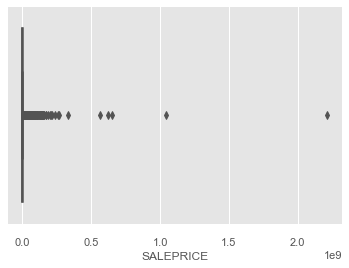

In [470]:
ax = sns.boxplot(x="SALEPRICE", data=housing_data)

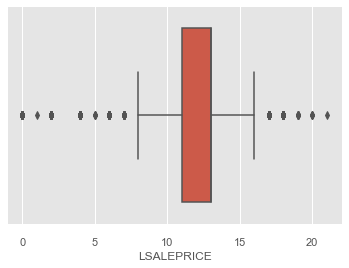

In [471]:
ax = sns.boxplot(x="LSALEPRICE", data=housing_data)

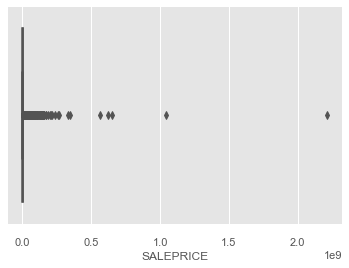

In [472]:
ax = sns.boxplot(x="SALEPRICE", data=housing_data_imputed)

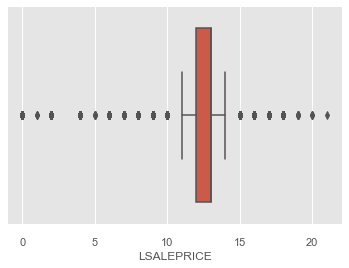

In [473]:
ax = sns.boxplot(x="LSALEPRICE", data=housing_data_imputed)

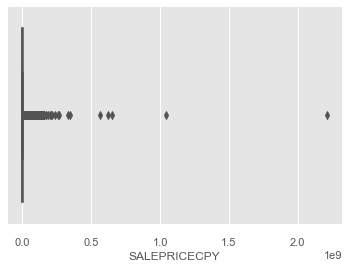

In [474]:
ax = sns.boxplot(x="SALEPRICECPY", data=housing_data_imputed)

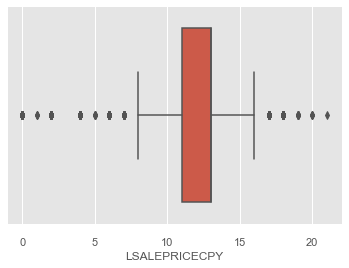

In [475]:
ax = sns.boxplot(x="LSALEPRICECPY", data=housing_data_imputed)

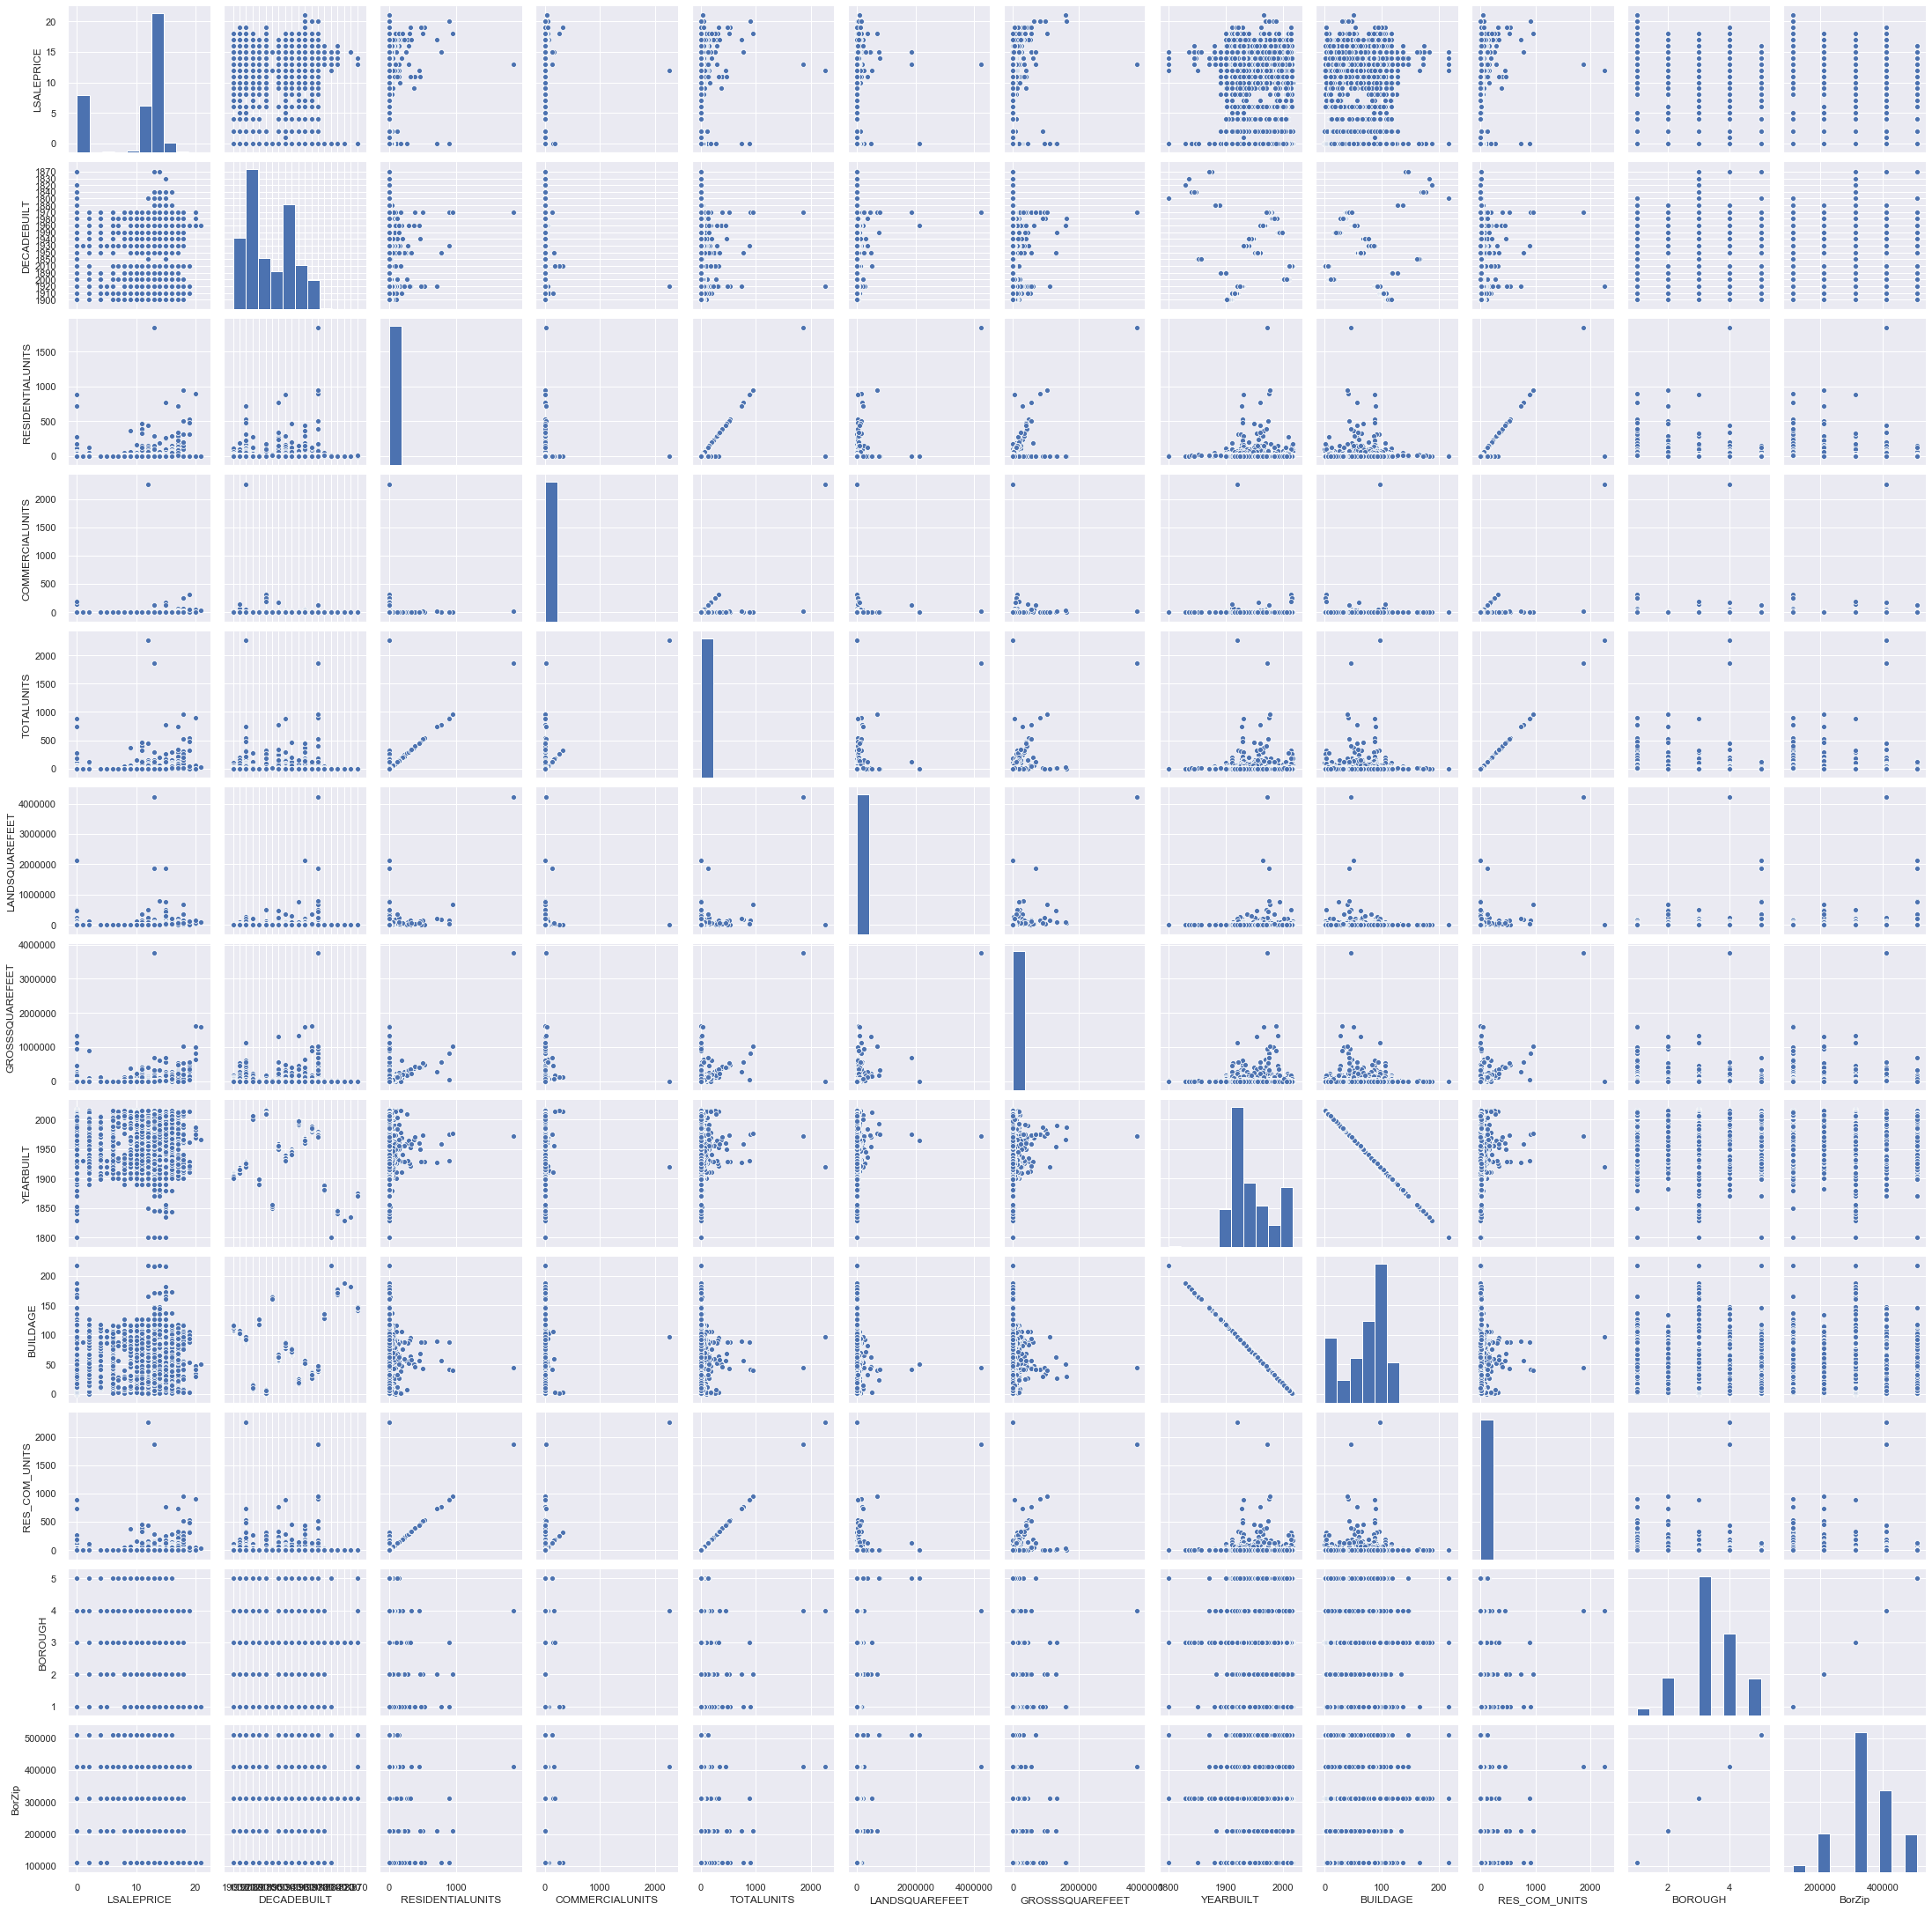

In [394]:
plot = sns.pairplot(housing_data[['LSALEPRICE',
                                  'DECADEBUILT', 'BUILDCLASSGENER', 
                                  'RESIDENTIALUNITS', 'COMMERCIALUNITS', 'TOTALUNITS',
                                  'LANDSQUAREFEET', 'GROSSSQUAREFEET','YEARBUILT',
                                   'BUILDAGE', 'RES_COM_UNITS', 'BOROUGH', 'BorZip']])
sns.set(rc={'figure.figsize':(80,70)})

# Base Line Clustering 

Adapted from https://github.com/jakemdrew/DataMiningNotebooks

In [476]:
ml_df_enc_regr["BorZip"].head(20)

0     110009
1     110009
2     110009
3     110009
4     110009
5     110009
6     110009
7     110009
8     110009
9     110009
10    110009
11    110011
15    110011
16    110011
17    110001
18    110011
19    110011
20    110011
21    110011
22    110011
Name: BorZip, dtype: int64

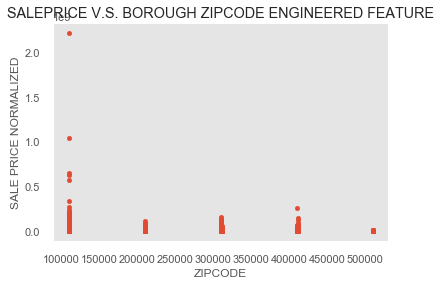

In [477]:
plt.style.use("ggplot")

%matplotlib inline
X1 = ml_df_enc_regr[['SALEPRICE', 'BorZip']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, 
             s=20)
plt.xlabel('ZIPCODE'), plt.ylabel('SALE PRICE NORMALIZED')
plt.grid()
plt.title('SALEPRICE V.S. BOROUGH ZIPCODE ENGINEERED FEATURE')
plt.show()

In [480]:
from sklearn.cluster import KMeans


X1 = ml_df_enc_regr[['LGROSSSQUAREFEET', 'BorZip']]

cls = KMeans(n_clusters=12, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = ml_df_enc_regr['LSALEPRICE']
X = ml_df_enc_regr[['LGROSSSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))
ML_std_scalr.fit(X)

X_scl = ML_std_scalr.transform(X)


regr = CappedLogLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)



cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

MAE = cross_val_score(regr,X_scl,y=y,cv=cv, scoring = 'neg_mean_absolute_error')

print ("Average MAE = ", abs(MAE.mean()))

Average MAE =  3.8268347962534444


Note, before we logged GROSSSQUAREFEET Average MAE ws 4.44

# BaseLine Capped linear regression for comparison 

In [481]:
regr = CappedLogLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)

y_regr = ml_df_enc_regr['LSALEPRICE'].values
X_regr = ml_df_enc_regr.drop(columns = ['SALEPRICE', 'LSALEPRICE'], axis = 1).values

ML_std_scalr.fit(X_regr)

X_regr_scl = ML_std_scalr.transform(X_regr)


cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

MAE = cross_val_score(regr,X_regr_scl, y_regr,cv=cv, scoring = 'neg_mean_absolute_error')

print ("Average MAE = ", abs(MAE.mean()))

Average MAE =  3.6439980888436723


##### Differnet Clustering - Numeric Attributes Only (Pre Dummy Variables)

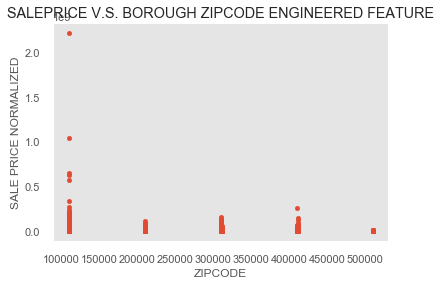

In [482]:
plt.style.use("ggplot")

%matplotlib inline
X1 = ml_df_enc_regr[['SALEPRICE', 'BorZip']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, 
             s=20)
plt.xlabel('ZIPCODE'), plt.ylabel('SALE PRICE NORMALIZED')
plt.grid()
plt.title('SALEPRICE V.S. BOROUGH ZIPCODE ENGINEERED FEATURE')
plt.show()

<span style="color:green">

# Sean's Additions

## Suggested workflow for organized layout

#### Pre-Clustering
>Run All three regression models with GridSearch to pick out best performing.  We use that model and benchmark MAE going forward

#### Clustering
>1. Identify the features we want to cluster on
>2. Plot variables to visually inspect whether or not there is any clustering potential
>3. If yes, Loop through n_clusters (based on best guess) to identify highest silhoutte score
>4. Plot 'Silhouette analysis' (cluster chart and labelled scatter plot) to see size and validity of each cluster
>5. Once it's deemed reasonable based on silhouette chart, run stacked data through regression GridSearch

# Regression Benchmark Model



Recall the dynamic range of the original data is between 0e0 to 2.2e9. For the regression task of this data we will use LSALEPRICE, as the target variable. Recall this is a log base 10 transformation of the SALEPRICE target variable, except where the 0s for sale price, the value has been changed to a 1, and then the log is taken. We took this approach since it is difficult to a sale price for these types of properties, since according to the data ontology, these are property transfers that occured outside of a traditional sale. Also, by taking the log of 1, this will compute to a zero value. This has scaled our values such that we can eliminate the large dynamic range of the target variable. 

We want to predict the LSALEPRICE for a property within a borough, for this task we will use MAE, since we are dealing with log scales, we can back transform the MAE to obtain the original scale or intrepret the results on a scaleless MAE and intrepret the multiplicative properties. In any event, the lower the MAE the better. For this reason we will use a capped linear regression as a baseline model, where the predictions will be "cut" to predict between (0e0, 2.1e1). 

In addition to the capped model, we are using two additional models, a Lasso regression and a gradient boosted regression model, as both models have parameters to allow us to penalize the model's L1 norm in the case of the Lasso regression for the sparcity of the encoded features and in the case of the GradientBoosting Regressor we can choose the number of stem and leaf nodes as well as whether the loss function is least squares or least absolute deviation, where the median of the predicted value is used. We also wanted to adjust the learning rates for the GradientBoosting Regressor in a reasonable amount of time given that we are doing 10 fold shuffle split cross validation. All three models were constructed and tested using 10 fold shuffle split cross validation, where all features were scaled and then followed by a grid search for the optimal hyper parameters.


#### Option 1: Capped Linear regression

This specific model caps the dynamic range of the predictions to our data set's target range of (0e0, 2.1e1) on scaled data followed by a grid search of optimal hyper parameters using a 10 fold 80/20 train test shuffle split. The only 2 parameters we are really adjusting for the capped linear regression is whether to normalize the features during fitting and whether to fit an intercept.

In [483]:
#Create a Linear Regression object and perform a grid search to find the best parameters
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

ML_std_scalr.fit(X_regr)

X_regr_scl = ML_std_scalr.transform(X_regr)


linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl,y_regr)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=CappedLinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': (True, False),
                         'normalize': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [484]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

regGridSearch.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)

In [485]:

#Create CappedLinearRegression predictions between 1e5 to 9.9e6 using the best parameters for our Linear Regression object
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

regEstimator = regGridSearch.best_estimator_

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
scoresResults_CappedReg =  EvaluateRegressionEstimator(regEstimator, X_regr_scl,y_regr, cv)

mae_avg_CappedLinearRegression = scoresResults_CappedReg['MAE'].mean()
scoresResults_CappedReg

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK00

The average MAE for all cv folds is: 			 1.5146e+06
The median absolute error for all cv folds is: 			 2.9803
The average MAE percentage (MAPE) for all cv folds is: 	 1.1615e+07
The average RMSE for all cv folds is: 			 5.7077e+07
*********************************************************
The average MSE for all cv folds is: 			 3.3473e+15
*********************************************************
The average score_time for all cv folds is: 			 0.019149
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in true_divide



MAE       MED          MAPE          RMSE           MSE  \
0  1.081879e+06  3.256165  6.309460e+06  4.889728e+07  2.390944e+15   
1  1.893285e+06  2.933502  8.668365e+06  6.468502e+07  4.184151e+15   
2  1.622816e+06  3.095879  1.232428e+07  5.988669e+07  3.586415e+15   
3  1.622816e+06  2.933411  2.957926e+07  5.988669e+07  3.586415e+15   
4  1.893285e+06  2.977295  1.259405e+07  6.468502e+07  4.184151e+15   
5  1.081879e+06  2.933243  5.039331e+06  4.889728e+07  2.390944e+15   
6  1.622816e+06  3.008865  1.374511e+07  5.988669e+07  3.586415e+15   
7  1.893285e+06  2.983246  8.694475e+06  6.468502e+07  4.184151e+15   
8  1.893285e+06  2.926239  1.439911e+07  6.468502e+07  4.184151e+15   
9  5.409411e+05  3.138748  4.795001e+06  3.457560e+07  1.195472e+15   

   SCORE_TIME  
0    0.017953  
1    0.017953  
2    0.018957  
3    0.022940  
4    0.020929  
5    0.017952  
6    0.016956  
7    0.017952  
8    0.019947  
9    0.019948

#### Option 2: LASSO

https://scikit-learn.org/stable/modules/linear_model.html#lasso

A Lasso Regression on scaled data, using a grid parameter search and the 10 fold 80/20 train test shuffle split.

We are testing different alphas and selection paramters. From the documentation, alpha is controlling the degree of sparsity of the estimated coefficients from our selected features. We also wanted to test whether reusing the solution of the previous call to fit as initialization effected the results, which is why we tested the warm start parameter. Also, we tested whether the selection being set to ‘random’ where a random coefficient is updated every iteration rather than looping over features sequentially as the case with cyclic made a difference.

In [506]:

#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

ML_std_scalr.fit(X_regr)

X_regr_scl = ML_std_scalr.transform(X_regr)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl,y_regr)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  5.1min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [507]:
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='random', tol=0.0001, warm_start=True)

After using the outputs for the best parameters from the lasso regression and the 10 fold 80/20 train test shuffle split, the best average MAE produced is *** . A slight improvement over the capped linear regression model, it is worth pointing out, while this model uses the same capped data, this model does not have a fixed dynamic range for its predictions as in the case of the capped linear regression. And the fact that Lasso is penalizing for the number of parameters by use of Alpha = *** is encouraging to know Lasso could be used for the dynamic ranges outside of what we caped our data to.

In [508]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=0, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X_regr_scl,y_regr, cv)

mae_avg_Lasso = scoresResults_Lasso['MAE'].mean()
scoresResults_Lasso

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATR

The average MAE for all cv folds is: 			 3.7706
The median absolute error for all cv folds is: 			 3.518
The average MAE percentage (MAPE) for all cv folds is: 	 26.653
The average RMSE for all cv folds is: 			 4.8448
*********************************************************
The average MSE for all cv folds is: 			 23.473
*********************************************************
The average score_time for all cv folds is: 			 0.017992
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide



MAE       MED       MAPE      RMSE        MSE  SCORE_TIME
0  3.776463  3.504483  26.558525  4.838045  23.406678    0.023072
1  3.757048  3.449200  26.368015  4.839168  23.417549    0.017323
2  3.798877  3.678433  27.004769  4.865224  23.670404    0.018028
3  3.744650  3.452386  26.337717  4.812624  23.161350    0.017001
4  3.737527  3.550365  27.393390  4.798459  23.025210    0.017953
5  3.760559  3.502382  27.326403  4.836444  23.391190    0.017953
6  3.796275  3.510695  25.822519  4.887896  23.891523    0.016955
7  3.749416  3.525295  26.094258  4.834536  23.372738    0.017126
8  3.761416  3.579117  25.698406  4.837575  23.402133    0.017442
9  3.823662  3.581353  27.928442  4.898210  23.992463    0.017069

#### Option 3: Gradient Boosting Regressor

https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting

A gradient boosing regressor on scaled data, using a grid search for optimal parameters and the 10 fold 80/20 train test shuffle split. From the documentation, the most important parameters are the learning rate and the n_estimators, when we adjust the learning rate we are accounting for overfitting via shrinkage, and by adjusting the n_estimators parameter we are controlling the number of weak learners or regression trees, we will be controlling the size of each tree by the max_depth parameter.

In [215]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

ML_std_scalr.fit(X_regr)


X_regr_scl = ML_std_scalr.transform(X_regr)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
linreg = GradientBoostingRegressor()

parameters = { 'loss' : ['ls', 'lad']
              ,'learning_rate' : [1e-3, 1e-1]
              ,'n_estimators': [100, 500] 
              ,'criterion': ['mae']
              ,'min_samples_split':[3,5]
              ,'min_samples_leaf': [10, 25]
              ,'max_leaf_nodes' : [25,40]
              ,'max_depth': [3,10]
              ,'max_features' : ['auto']
              ,'subsample' : [1e-2]
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl , y_regr)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 15.9min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 38.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 65.1min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 105.3min
[Parallel(n_jobs=8)]: Done 1280 out of 1280 | elapsed: 108.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min...
             param_grid={'criterion': ['mae'], 'learning_rate': [0.001, 0.1],
                         'loss': ['ls', 'lad'], 'max_depth': [3, 10],
              

In [216]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
#Display the best estimator parameters
regGridSearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

After using the outputs for the best parameters from the gradient boosting regression and the 10 fold 80/20 train test shuffle split, the best average MAE produced is 3.70e5. While this model does not have a fixed dynamic range as in the case of the capped linear regression, we see it has a seemingly different average MAE as compared to the LASSO regression.

In [218]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation
regEstimator = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_GradientBoostingRegressor = EvaluateRegressionEstimator(regEstimator, X_regr_scl , y_regr, cv)


mae_avg_GradientBoostingRegressor = scoresResults_GradientBoostingRegressor['MAE'].mean()
scoresResults_GradientBoostingRegressor

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATR

The average MAE for all cv folds is: 			 3.4098
The average MAE percentage (MAPE) for all cv folds is: 	 22.162
The average RMSE for all cv folds is: 			 5.2412
*********************************************************
The average MSE for all cv folds is: 			 27.472
*********************************************************
The average score_time for all cv folds is: 			 0.36788
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide



MAE       MAPE      RMSE        MSE  SCORE_TIME
0  3.358173  21.704954  5.194814  26.986087    0.366541
1  3.466740  22.553354  5.213612  27.181751    0.362042
2  3.425378  22.761855  5.274399  27.819283    0.368027
3  3.427783  22.095550  5.267167  27.743046    0.363038
4  3.417488  23.617809  5.178098  26.812699    0.356057
5  3.368680  22.654363  5.223297  27.282836    0.372014
6  3.464106  21.343812  5.318919  28.290898    0.384980
7  3.320563  20.960820  5.209191  27.135673    0.349077
8  3.406044  20.965889  5.243583  27.495161    0.383016
9  3.442753  22.957548  5.288566  27.968932    0.374009

## Regression Model Benchmark Conclusion: 

<span style="color:green">
    
# -----------------------------------WORKFLOW EXAMPLE----------------------------------------

## KMean

<span style="color:blue">

#### 1. Plot data to visually identify clusters

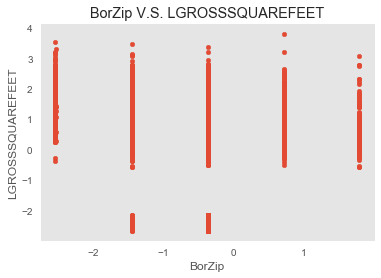

In [302]:
plt.style.use("ggplot")

%matplotlib inline
X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, 
             s=20)
plt.xlabel('BorZip'), plt.ylabel('LGROSSSQUAREFEET')
plt.grid()
plt.title('BorZip V.S. LGROSSSQUAREFEET')
plt.show()

<span style="color:green">
    
    
## Alternative Plotting - A little easier to identify clusters

#### LGROSSSQUAREFEET vs BorZip

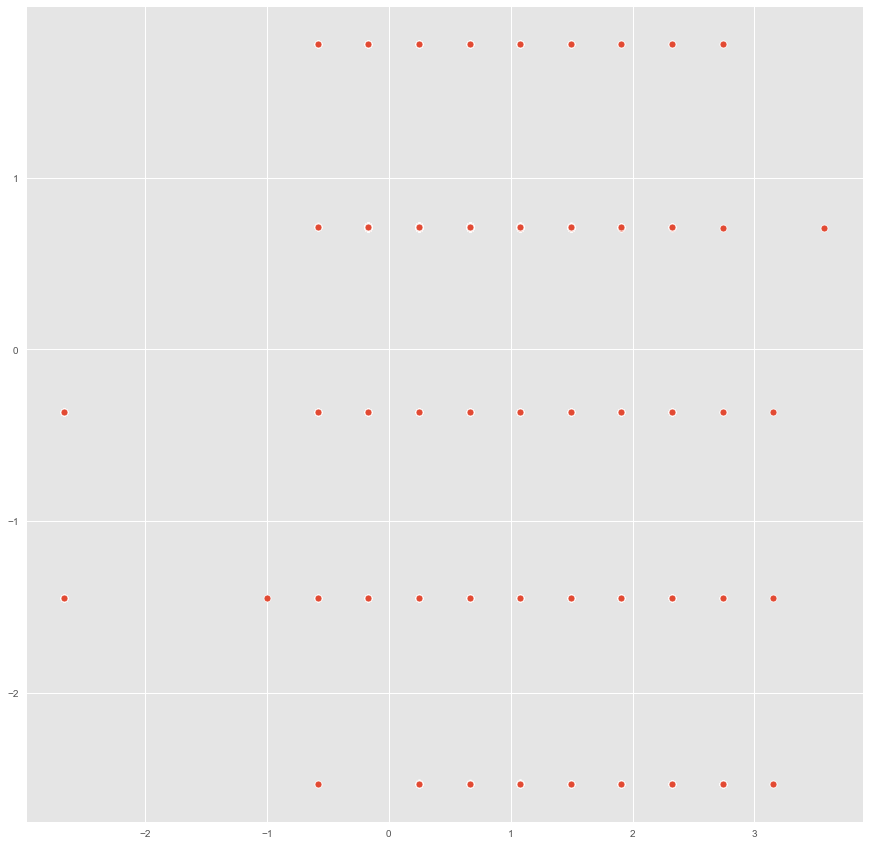

In [303]:
#Plot our data to visualize potential clusters and determine optimal clustering method

X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']].values
plt.figure(figsize=(15,15))
sns.scatterplot(X1[:,0],X1[:,1]);



Above, we can see that there is some clear separation although many data points are densly packed.  

Below we fill in our target variable to determine whehter or not there are any practical clusters appearing.  It looks like there is some consistent color overlay asside from the zero values, so we will proceed. It also appears that KMeans would be a sufficient clustering method given the separation of the datapoints.

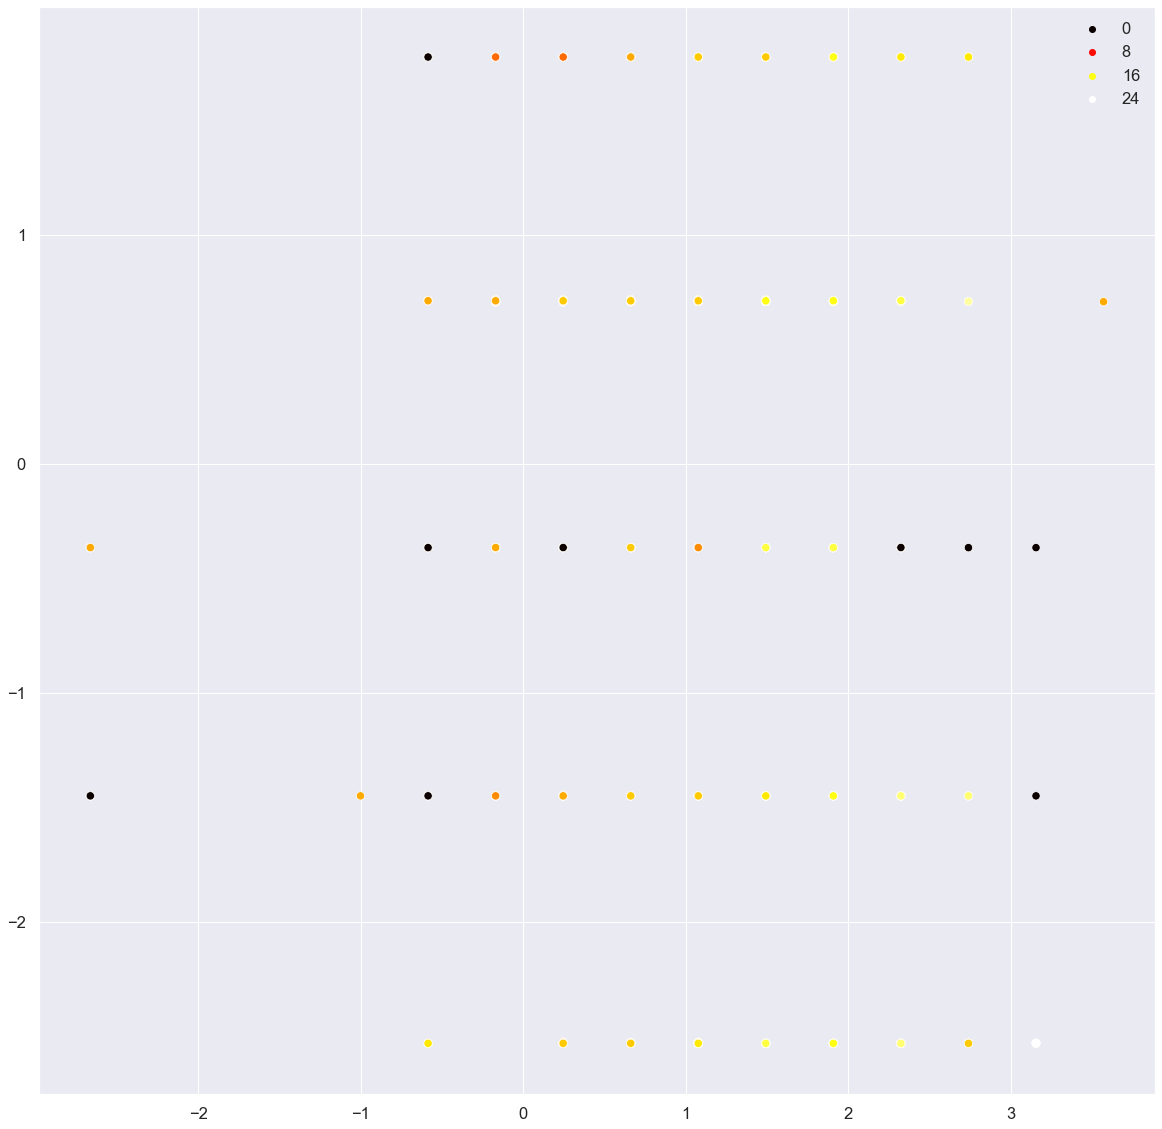

In [304]:
#Fill in LSALEPRICE
plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
sns.scatterplot(x=X1[:,0],y=X1[:,1],\
                     hue=y_scl, s=70, palette="hot");#,palette="RdBu");

<span style="color:blue">

#### 2. Loop through n_clusters to idnetify highest overall Silhouette score


Number of clusters =  8
Silhouette score =  0.8538166185482725

Number of clusters =  9
Silhouette score =  0.8569046941187238

Number of clusters =  10
Silhouette score =  0.8637032922945013

Number of clusters =  11
Silhouette score =  0.8753121178128499

Number of clusters =  12
Silhouette score =  0.9049784314911898

Number of clusters =  13
Silhouette score =  0.9114474038939964


Text(0.5, 1.0, 'Silhouette score vs number of clusters')

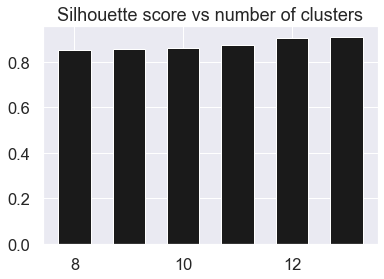

In [305]:
from sklearn.cluster import KMeans
from sklearn import metrics 

scores = []

clusters = np.arange(8,14)


X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']]

for i in clusters: 
    cls = KMeans(n_clusters=i, init='k-means++',random_state=1)
    cls.fit(X1)
    score = metrics.silhouette_score(X1, cls.labels_, metric = 'euclidean', sample_size = len(X1)) 
    
    print('\nNumber of clusters = ', i)
    print('Silhouette score = ', score)
    
    scores.append(score)
    
    
plt.figure()
plt.bar(clusters, scores, width=0.6, color='k', align='center')
plt.title('Silhouette score vs number of clusters')

# plt.figure()
# plt.scatter(X1[:,0], X1[:,1], color = 'k', s=30, marker = 'o', facecolors='none')
# x_min, x_max = min(X1[:,0]) - 1, max(X1[:,0]) + 1 
# y_min, y_max = min(X1[:,1]) - 1 , max(X1[:,1]) + 1 
# plt.title('Input Cluster')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

# plt.show()


<span style="color:blue">

#### 3. Plot top three n_cluster values to visually inspect clusters

Automatically created module for IPython interactive environment
For n_clusters = 17 The average silhouette_score is : 0.9447327756781668
For n_clusters = 18 The average silhouette_score is : 0.9579613767743875
For n_clusters = 19 The average silhouette_score is : 0.9660255467438568
For n_clusters = 20 The average silhouette_score is : 0.9747032217040577


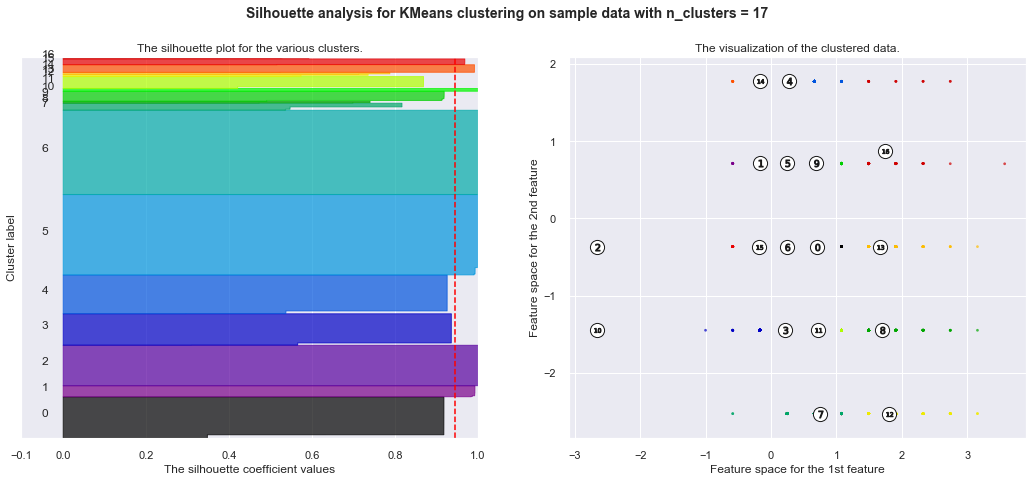

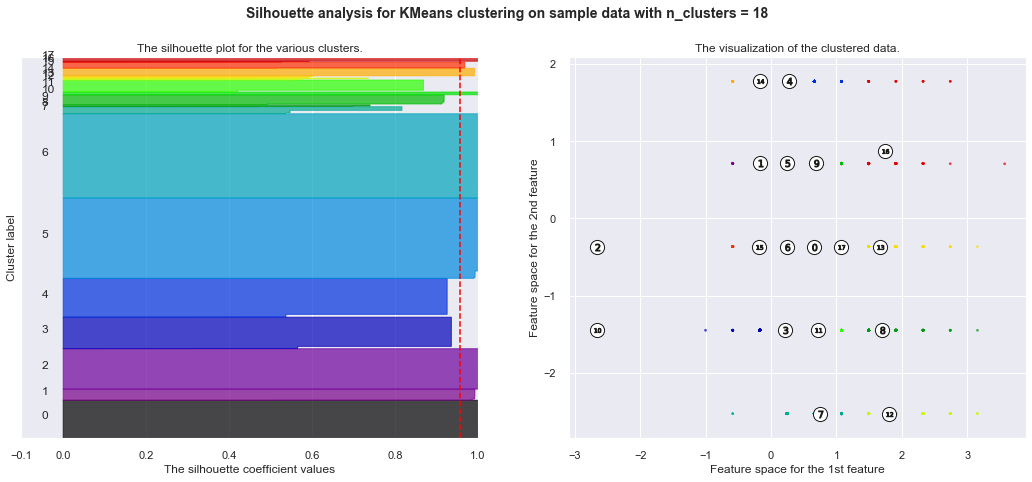

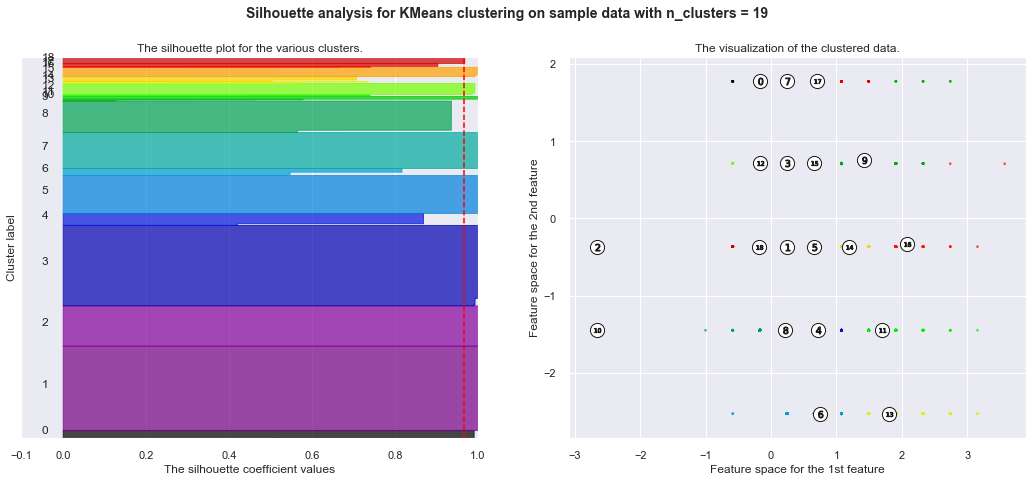

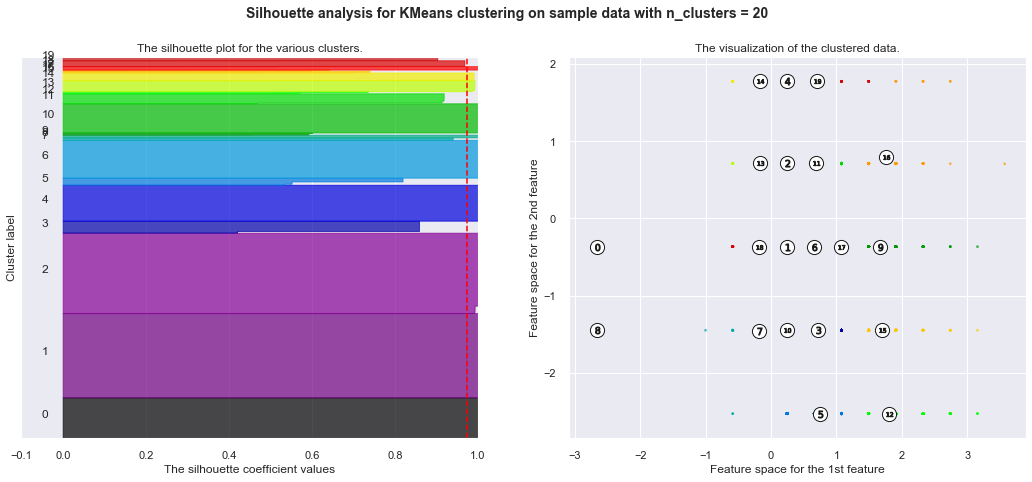

In [316]:
#Code adopted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


X =  X_scl_df[['LGROSSSQUAREFEET', 'BorZip']].values
y = y_scl

range_n_clusters = [17, 18, 19, 20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

## KMEAN   - start Rajesh changes

<span style="color:blue">

#### 1. Loop through n_clusters to idnetify highest overall Silhouette score

We will be using Silhouette analysis to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

Based on Silhouette score, following are the top three clusters for ['COMMERCIALUNITS','BorZip'] out of all the combinations ran. We shall further plot top three n_cluster values to visually inspect for ['COMMERCIALUNITS','BorZip'] cluster


Number of clusters =  7
Silhouette score =  0.9755055033623479

Number of clusters =  9
Silhouette score =  0.976567861449096

Number of clusters =  19
Silhouette score =  0.9697831432578858




In [487]:
from sklearn.cluster import KMeans
from sklearn import metrics 



clusters = np.arange(7, 21, 2)

C=[]


X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']]
X2 = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X3 = X_scl_df[['TOTALUNITS', 'BorZip']]
X4 = X_scl_df[['LLANDSQUAREFEET', 'BorZip']]
X5 = X_scl_df[['YEARBUILT', 'BorZip']]
X6 = X_scl_df[['BUILDAGE', 'BorZip']]
X7 = X_scl_df[['RES_COM_UNITS', 'BorZip']]
X8 = X_scl_df[['RES_COM_UNITS', 'BUILDAGE']]
X9 = X_scl_df[['RES_COM_UNITS', 'YEARBUILT']]

C.append(X1)
C.append(X2)
C.append(X3)
C.append(X4)
C.append(X5)
C.append(X6)
C.append(X7)
C.append(X8)
C.append(X9)

 
for x in C:
    
    print('----------------------------------')
    print(x.columns.values)
    print('----------------------------------')
    scores = []
    for i in clusters: 
        
        cls = KMeans(n_clusters=i, init='k-means++',random_state=1)
        cls.fit(x)
        score = metrics.silhouette_score(x, cls.labels_, metric = 'euclidean', sample_size = len(x)) 

        print('\nNumber of clusters = ', i)
        print('Silhouette score = ', score)

        #scores.append(score)
    
    
    #plt.figure()
    #plt.bar(clusters, scores, width=0.6, color='k', align='center')
    #plt.title('Silhouette score vs number of clusters')

# plt.figure()
# plt.scatter(X1[:,0], X1[:,1], color = 'k', s=30, marker = 'o', facecolors='none')
# x_min, x_max = min(X1[:,0]) - 1, max(X1[:,0]) + 1 
# y_min, y_max = min(X1[:,1]) - 1 , max(X1[:,1]) + 1 
# plt.title('Input Cluster')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

# plt.show()
  

----------------------------------
['LGROSSSQUAREFEET' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.8458127676509754

Number of clusters =  9
Silhouette score =  0.8569046941187496

Number of clusters =  11
Silhouette score =  0.8753121178129477

Number of clusters =  13
Silhouette score =  0.9114474038938036

Number of clusters =  15
Silhouette score =  0.9229506351749617

Number of clusters =  17
Silhouette score =  0.9531155028334063

Number of clusters =  19
Silhouette score =  0.9646583329414169
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.9755055033623479

Number of clusters =  9
Silhouette score =  0.976567861449096

Number of clusters =  11
Silhouette score =  0.9638538075190244

Number of clusters =  13
Silhouette score =  0.9643303052968459

Number of clusters =  15
Silhouette score =  0.963352760441889

Number of clusters =  17
S

<span style="color:blue">

#### 2. Plot top three n_cluster values to visually inspect clusters

Automatically created module for IPython interactive environment
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------
For n_clusters = 7 The average silhouette_score is : 0.9755055033623516
For n_clusters = 9 The average silhouette_score is : 0.9765678614491
For n_clusters = 19 The average silhouette_score is : 0.9655880511966264


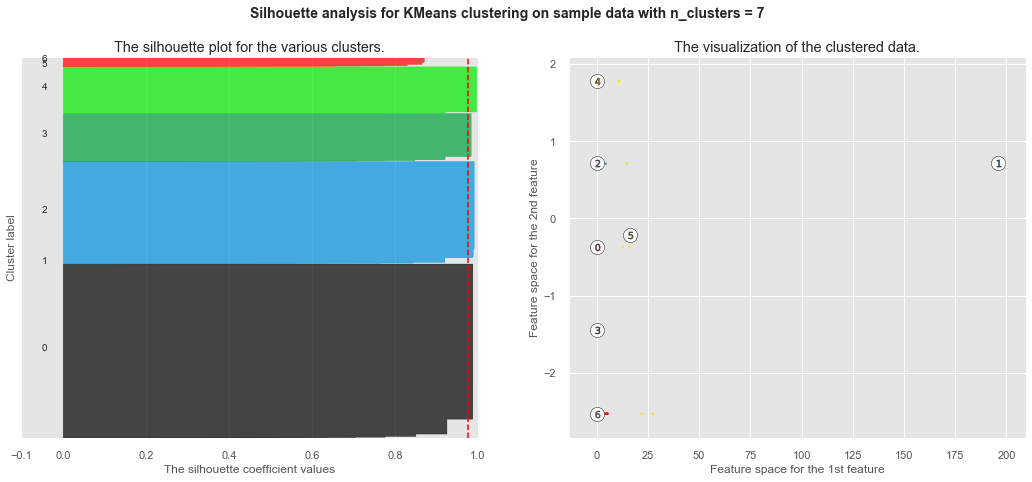

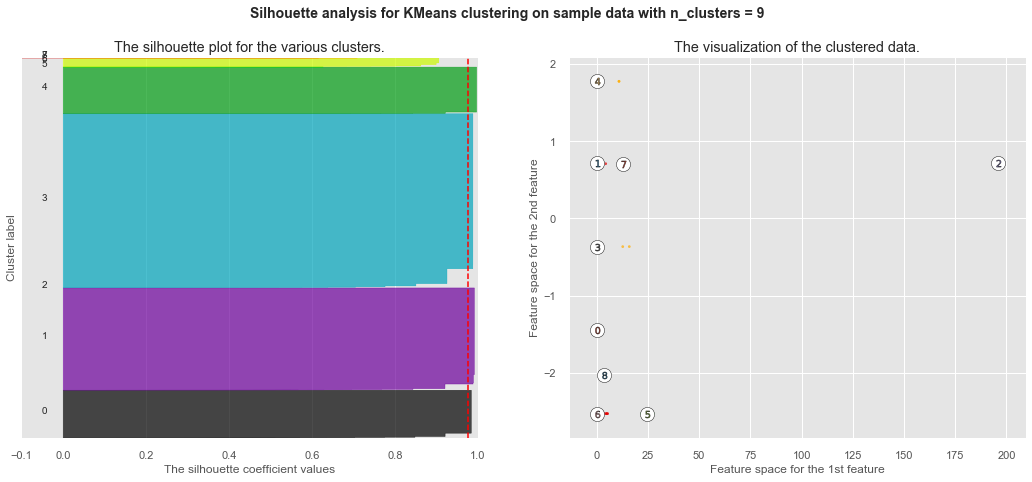

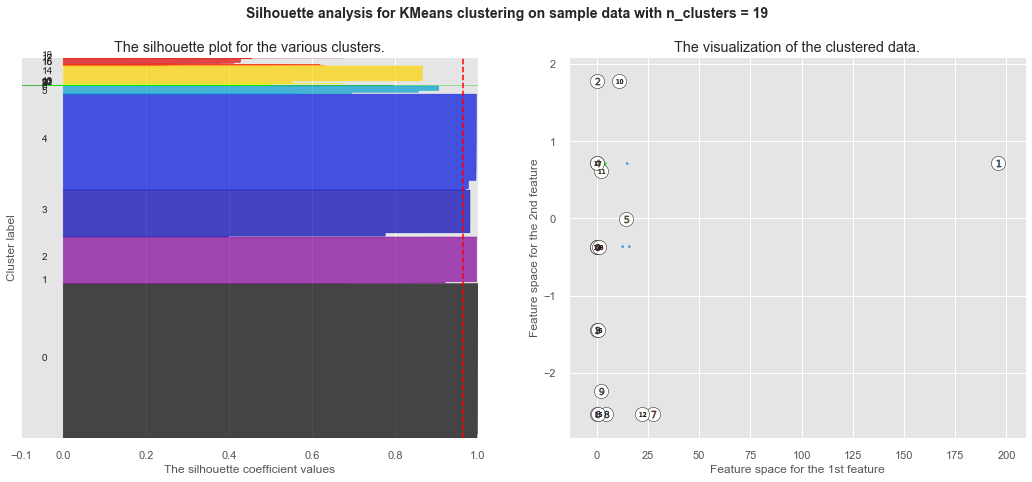

In [489]:

#Code adopted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.



X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]

y = y_scl

range_n_clusters = [7, 9, 19]

    
print('----------------------------------')
print(X.columns.values)
print('----------------------------------')

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

It appears that 9 clusters has the most viable clusters

<span style="color:blue">

#### 3. Test reduced dataset against regression model and compare to benchmark

Lasso Regression

In [491]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Recluster and stack cluster values onto dataset


X =  X_scl_df[['COMMERCIALUNITS', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['COMMERCIALUNITS', 'BorZip']]

cls = KMeans(n_clusters=9, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

#Run clustered dataset through GridSearch and regression

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X,y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   21.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [492]:
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='random', tol=0.0001, warm_start=True)

In [493]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=959, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X, y, cv)

mae_avg_Lasso = scoresResults_Lasso['MAE'].mean()
scoresResults_Lasso

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATR

The average MAE for all cv folds is: 			 3.8999
The median absolute error for all cv folds is: 			 3.6843
The average MAE percentage (MAPE) for all cv folds is: 	 27.312
The average RMSE for all cv folds is: 			 4.9751
*********************************************************
The average MSE for all cv folds is: 			 24.752
*********************************************************
The average score_time for all cv folds is: 			 0.0051874
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide



MAE       MED       MAPE      RMSE        MSE  SCORE_TIME
0  3.911967  3.690105  27.255672  4.968773  24.688704    0.005983
1  3.882490  3.666226  27.043918  4.960971  24.611232    0.002993
2  3.935984  3.728299  27.771339  5.010418  25.104285    0.004987
3  3.862389  3.702300  26.810590  4.935596  24.360104    0.012966
4  3.879045  3.701510  28.230164  4.940759  24.411103    0.005984
5  3.885558  3.685347  27.936953  4.961860  24.620053    0.002991
6  3.916589  3.664990  26.458539  5.001336  25.013362    0.004987
7  3.884756  3.665342  26.796331  4.969215  24.693097    0.003997
8  3.880150  3.683243  26.237853  4.959958  24.601182    0.003995
9  3.959659  3.643529  28.575711  5.041721  25.418952    0.002990

Baseline LASSO: The median absolute error for all cv folds is: 3.518

KMeans, n_clusters=9
The median absolute error for all cv folds is:3.6843

## Agglomerative Cluster

<span style="color:blue">

#### 1. Loop through n_clusters to idnetify highest overall Silhouette score

Based on Silhouette score, following are the top three clusters out of all the combinations ran. We shall further plot top three n_cluster values to visually inspect.


['LLANDSQUAREFEET' 'BorZip']

Number of clusters =  19
Silhouette score =  0.9824932656271578


['COMMERCIALUNITS' 'BorZip']

Number of clusters =  11
Silhouette score =  0.9773212288032553

Number of clusters =  9
Silhouette score =  0.9756622513207825

In [497]:
from sklearn.cluster import KMeans
from sklearn import metrics 



clusters = np.arange(7, 21, 2)

C=[]


X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']]
X2 = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X3 = X_scl_df[['TOTALUNITS', 'BorZip']]
X4 = X_scl_df[['LLANDSQUAREFEET', 'BorZip']]
X5 = X_scl_df[['YEARBUILT', 'BorZip']]
X6 = X_scl_df[['BUILDAGE', 'BorZip']]
X7 = X_scl_df[['RES_COM_UNITS', 'BorZip']]
X8 = X_scl_df[['RES_COM_UNITS', 'BUILDAGE']]
X9 = X_scl_df[['RES_COM_UNITS', 'YEARBUILT']]

C.append(X1)
C.append(X2)
C.append(X3)
C.append(X4)
C.append(X5)
C.append(X6)
C.append(X7)
C.append(X8)
C.append(X9)

 
for x in C:
    
    print('----------------------------------')
    print(x.columns.values)
    print('----------------------------------')
    scores = []
    for i in clusters: 
        cls = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage='ward')
        cls.fit(x)
        score = metrics.silhouette_score(x, cls.labels_, metric = 'euclidean', sample_size = len(x)) 

        print('\nNumber of clusters = ', i)
        print('Silhouette score = ', score)

        #scores.append(score)
    
    
    #plt.figure()
    #plt.bar(clusters, scores, width=0.6, color='k', align='center')
    #plt.title('Silhouette score vs number of clusters')

# plt.figure()
# plt.scatter(X1[:,0], X1[:,1], color = 'k', s=30, marker = 'o', facecolors='none')
# x_min, x_max = min(X1[:,0]) - 1, max(X1[:,0]) + 1 
# y_min, y_max = min(X1[:,1]) - 1 , max(X1[:,1]) + 1 
# plt.title('Input Cluster')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

# plt.show()
  


----------------------------------
['LGROSSSQUAREFEET' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.8454230950589191

Number of clusters =  9
Silhouette score =  0.8584972948901837

Number of clusters =  11
Silhouette score =  0.8783749701595255

Number of clusters =  13
Silhouette score =  0.9103395744981

Number of clusters =  15
Silhouette score =  0.9265949782568762

Number of clusters =  17
Silhouette score =  0.9545739272483915

Number of clusters =  19
Silhouette score =  0.9697830061593753
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.9747939973698606

Number of clusters =  9
Silhouette score =  0.9756622513207825

Number of clusters =  11
Silhouette score =  0.9773212288032553

Number of clusters =  13
Silhouette score =  0.9663550862048973

Number of clusters =  15
Silhouette score =  0.9653032796388589

Number of clusters =  17
Si

<span style="color:blue">

#### 2. Plot top three n_cluster values to visually inspect clusters

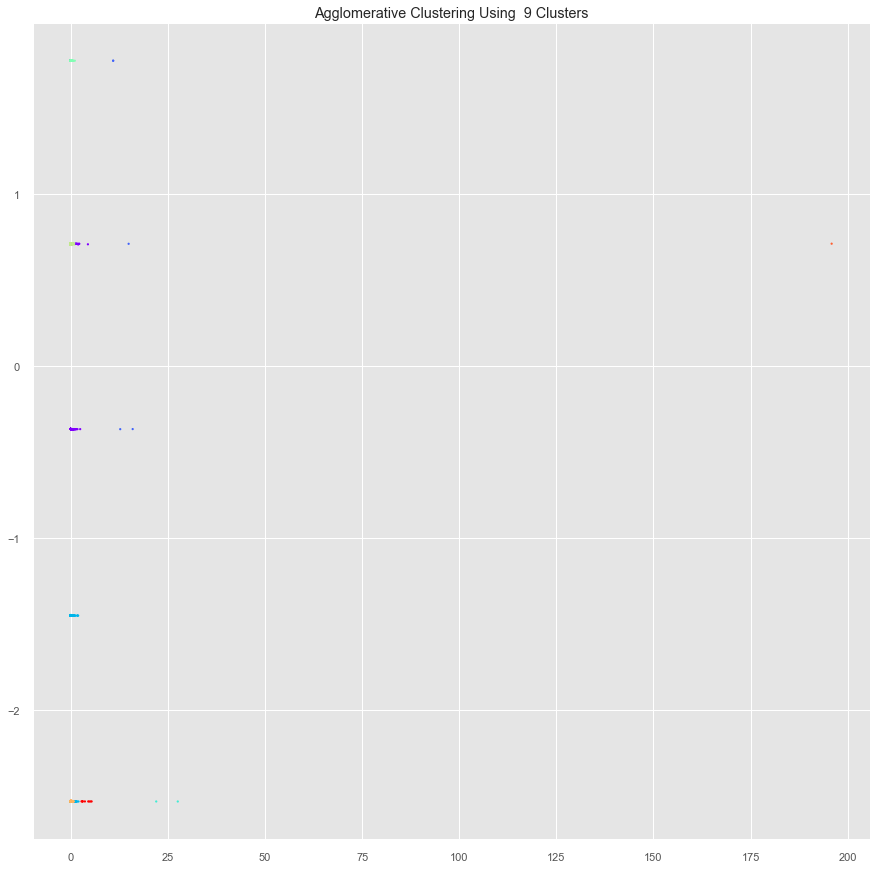

In [531]:

X1 = X_scl_df[['COMMERCIALUNITS', 'BorZip']].values
nclust = 9

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage='ward')
labels = spc.fit_predict(X1)

plt.figure(figsize=(15, 15))
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)
plt.title('Agglomerative Clustering Using  %d Clusters' % nclust)
plt.show()



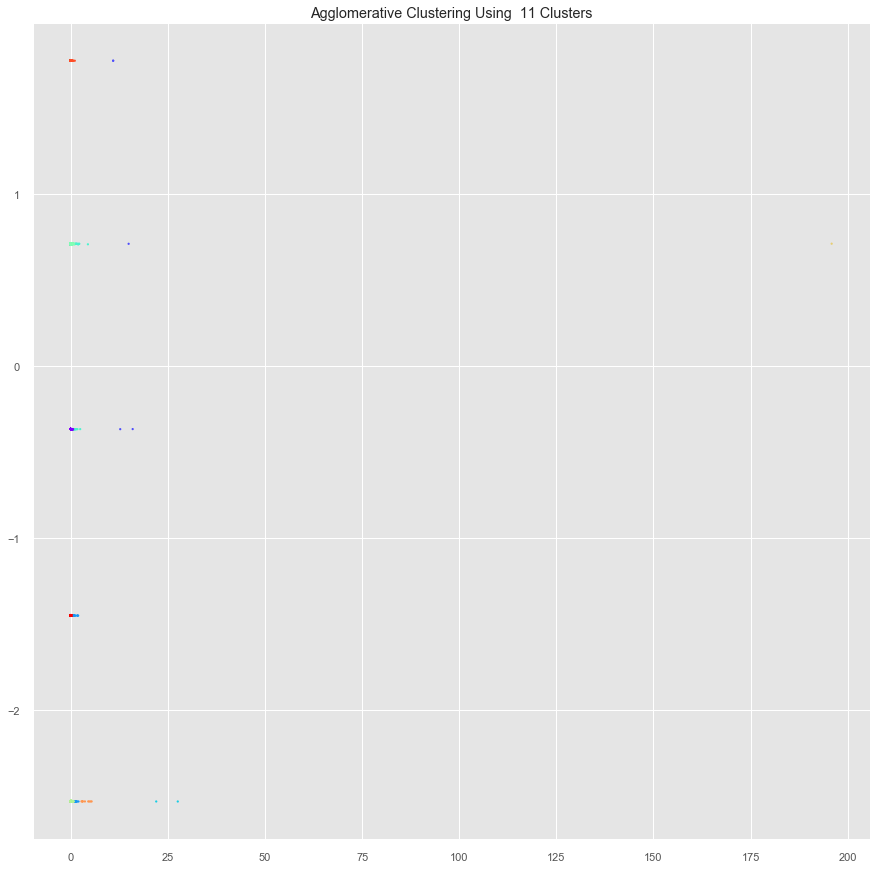

In [532]:

X1 = X_scl_df[['COMMERCIALUNITS', 'BorZip']].values
nclust = 11

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage='ward')
labels = spc.fit_predict(X1)

plt.figure(figsize=(15, 15))
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)
plt.title('Agglomerative Clustering Using  %d Clusters' % nclust)
plt.show()

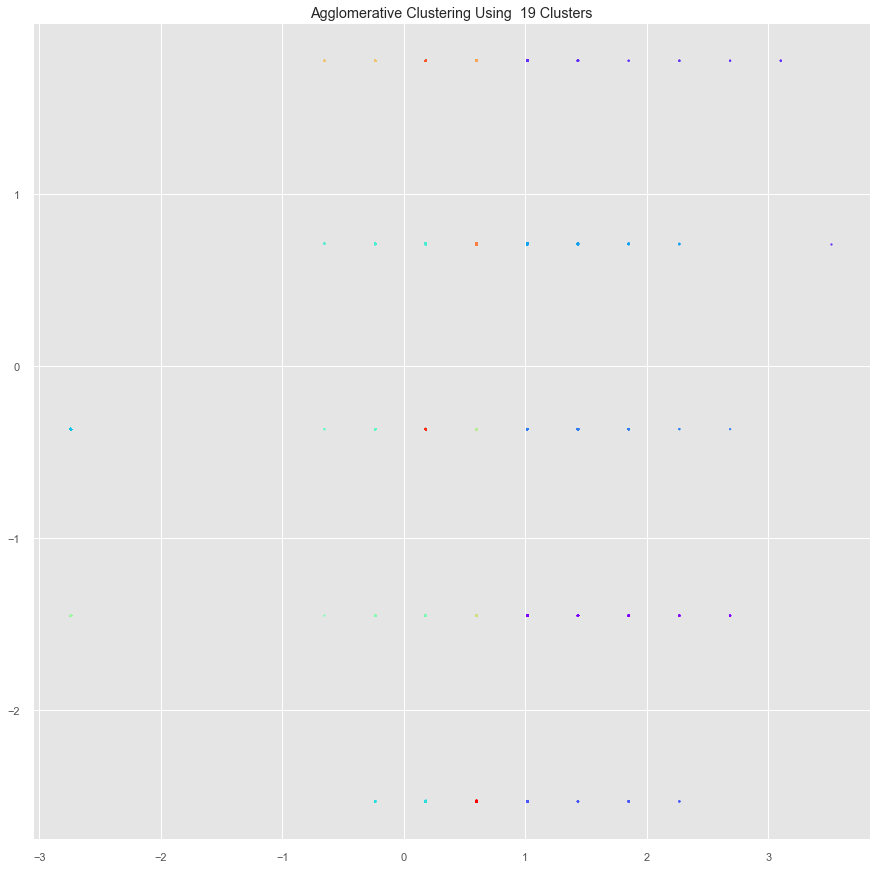

In [533]:

X1 = X_scl_df[['LLANDSQUAREFEET', 'BorZip']].values
nclust = 19

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage='ward')
labels = spc.fit_predict(X1)

plt.figure(figsize=(15, 15))
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)
plt.title('Agglomerative Clustering Using  %d Clusters' % nclust)
plt.show()


In [502]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Recluster and stack cluster values onto dataset


X =  X_scl_df[['LLANDSQUAREFEET', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['LLANDSQUAREFEET', 'BorZip']]

cls = AgglomerativeClustering(n_clusters=19, affinity = 'euclidean', linkage='ward')
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['LLANDSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

#Run clustered dataset through GridSearch and regression

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X,y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   16.1s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

<span style="color:blue">

#### 3. Test reduced dataset against regression model and compare to benchmark

Lasso Regression

In [503]:
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=True)

In [504]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=959, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X, y, cv)

mae_avg_Lasso = scoresResults_Lasso['MAE'].mean()
scoresResults_Lasso

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATR

The average MAE for all cv folds is: 			 3.95
The median absolute error for all cv folds is: 			 3.7003
The average MAE percentage (MAPE) for all cv folds is: 	 27.458
The average RMSE for all cv folds is: 			 4.9859
*********************************************************
The average MSE for all cv folds is: 			 24.86
*********************************************************
The average score_time for all cv folds is: 			 0.0066818
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide



MAE       MED       MAPE      RMSE        MSE  SCORE_TIME
0  3.958018  3.776676  27.407270  4.973608  24.736773    0.011967
1  3.934096  3.708960  27.182960  4.973415  24.734853    0.002992
2  3.981722  3.788641  27.841984  5.021139  25.211841    0.001995
3  3.917079  3.777713  26.944243  4.949249  24.495065    0.003985
4  3.931020  3.747326  28.366869  4.954804  24.550085    0.006981
5  3.936160  3.685374  28.099422  4.976171  24.762280    0.011968
6  3.963260  3.642739  26.620095  5.006432  25.064358    0.008977
7  3.934590  3.691661  26.939745  4.975104  24.751661    0.010971
8  3.930111  3.680435  26.418566  4.969579  24.696715    0.002992
9  4.013669  3.666113  28.757680  5.059177  25.595274    0.003989

Baseline LASSO: The median absolute error for all cv folds is: 3.518

Agglomerative, n_clusters=19 

The median absolute error for all cv folds is:3.7003

### end Rajesh changes

<span style="color:green">
    
# -------------------------------END OF WORKFLOW EXAMPLE----------------------------------

Test out Agglomerative 

<span style="color:red">
    
# Takes a while to run

In [ ]:
from sklearn.cluster import AgglomerativeClustering

X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']]
kmeans_LGSF_BZ_results = []

for i in range (4, 16):
    cls = AgglomerativeClustering(n_clusters=15, affinity = 'euclidean', linkage='ward')
    cls.fit(X1)
    newfeature = cls.labels_ # the labels from kmeans clustering

    y = y_scl
    X = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']]
    X = np.column_stack((X,pd.get_dummies(newfeature)))


    regr = CappedLogLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)



    cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

    MAE = cross_val_score(regr,X,y=y,cv=cv, scoring = 'neg_mean_absolute_error')
    results = {"n_clusters": i, 'MAE': abs(MAE.mean())}
    kmeans_LGSF_BZ_results.append(results)
    #print ("Average MAE = ", abs(MAE.mean()))

kmeans_LGSF_BZ_results_df = pd.DataFrame.from_dict(kmeans_LGSF_BZ_results)
kmeans_LGSF_BZ_results_df

In [121]:
X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']]

cls = AgglomerativeClustering(n_clusters=30, affinity = 'euclidean', linkage='ward')
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))


regr = CappedLogLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)



cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

MAE = cross_val_score(regr,X,y=y,cv=cv, scoring = 'neg_mean_absolute_error')

print ("Average MAE = ", abs(MAE.mean()))

Average MAE =  3.816832471851547


Visualize Agglomerative Clustering

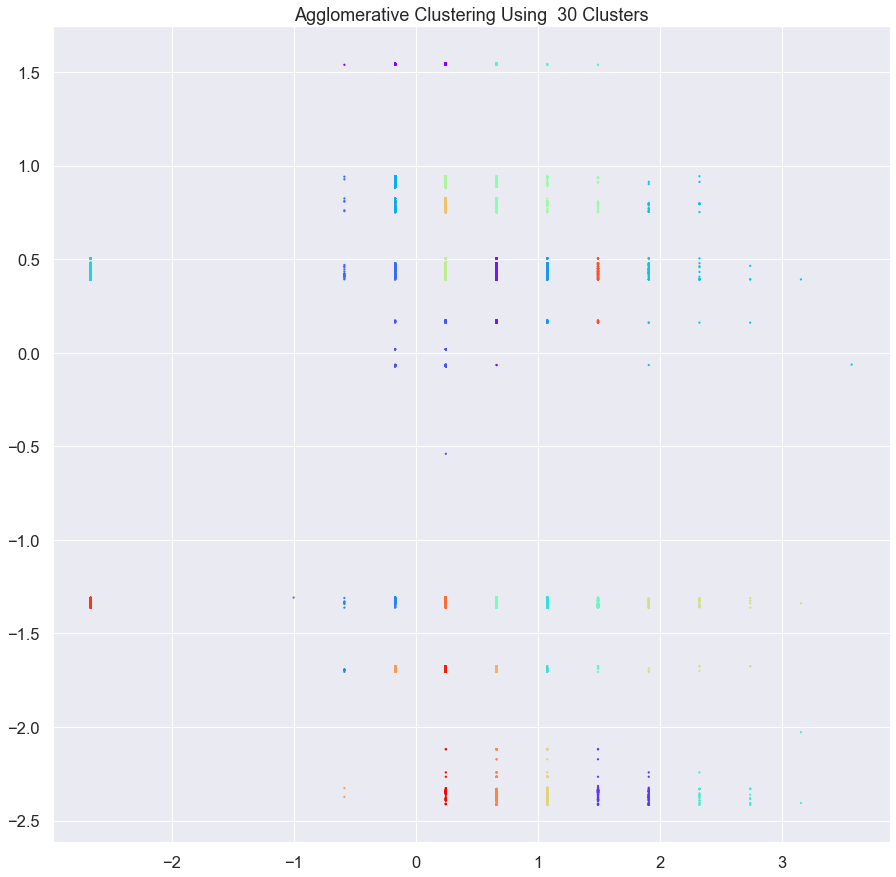

In [125]:
X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']].values
nclust = 30

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage='ward')
labels = spc.fit_predict(X1)

plt.figure(figsize=(15, 15))
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)
plt.title('Agglomerative Clustering Using  %d Clusters' % nclust)
plt.show()

#### BUILDAGE vs BorZip

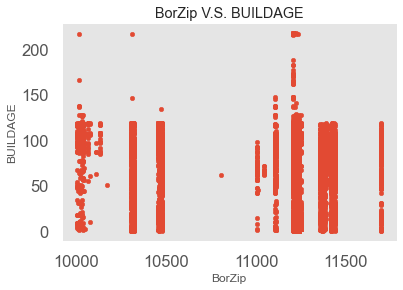

In [303]:
plt.style.use("ggplot")

%matplotlib inline
X1 = X_scl_df[['BUILDAGE', 'BorZip']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, 
             s=20)
plt.xlabel('BorZip'), plt.ylabel('BUILDAGE')
plt.grid()
plt.title('BorZip V.S. BUILDAGE')
plt.show()

Test out KMeans - Looks to be about 10 clusters

In [299]:
X1 = X_scl_df[['BUILDAGE', 'BorZip']]

cls = KMeans(n_clusters=12, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['BUILDAGE', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

regr = CappedLogLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)



cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

MAE = cross_val_score(regr,X,y=y,cv=cv, scoring = 'neg_mean_absolute_error')

print ("Average MAE = ", abs(MAE.mean()))

Average MAE =  3.8426240667148712


Test out Agglomerative

In [300]:
X1 = X_scl_df[['BUILDAGE', 'BorZip']]

cls = AgglomerativeClustering(n_clusters=12, affinity = 'euclidean', linkage='ward')
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['BUILDAGE', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

regr = CappedLogLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)



cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

MAE = cross_val_score(regr,X,y=y,cv=cv, scoring = 'neg_mean_absolute_error')

print ("Average MAE = ", abs(MAE.mean()))

Average MAE =  3.8345161540980186


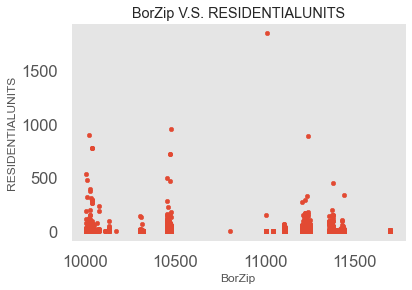

In [304]:
plt.style.use("ggplot")

%matplotlib inline
X1 = X_scl_df[['RESIDENTIALUNITS', 'BorZip']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, 
             s=20)
plt.xlabel('BorZip'), plt.ylabel('RESIDENTIALUNITS')
plt.grid()
plt.title('BorZip V.S. RESIDENTIALUNITS')
plt.show()

Test out KMeans

In [311]:
X1 = X_scl_df[['RESIDENTIALUNITS', 'BorZip']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['RESIDENTIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

regr = CappedLogLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)



cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

MAE = cross_val_score(regr,X,y=y,cv=cv, scoring = 'neg_mean_absolute_error')

print ("Average MAE = ", abs(MAE.mean()))

Average MAE =  3.8642980296672946


Test out Agglomerative

In [312]:
X1 = X_scl_df[['RESIDENTIALUNITS', 'BorZip']]

cls = AgglomerativeClustering(n_clusters=12, affinity = 'euclidean', linkage='ward')
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['RESIDENTIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

regr = CappedLogLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

MAE = cross_val_score(regr,X,y=y,cv=cv, scoring = 'neg_mean_absolute_error')

print ("Average MAE = ", abs(MAE.mean()))

Average MAE =  3.863479688625079


<span style="color:blue">

Possibly delete, maybe investigate 3D PCA.


# Investigation of Numeric Variables and Feature Reduction 

In [118]:
# Code adopted from https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
#TSNE for numeric variables as TSNE works better on dense datasets like PCA
housing_data_num = housing_data.select_dtypes(include=[np.number])
housing_data_num.head(3)

BOROUGH  BLOCK  LOT  RESIDENTIALUNITS  COMMERCIALUNITS  TOTALUNITS  \
0        1    392    6                 5                0           5   
1        1    402   21                10                0          10   
2        1    404   55                 6                0           6   

   LANDSQUAREFEET  GROSSSQUAREFEET  YEARBUILT  TAXCLASSATTIMEOFSALE  \
0            1633             6440       1900                     2   
1            2272             6794       1913                     2   
2            2369             4615       1900                     2   

   SALEPRICE  BUILDAGE  RES_COM_UNITS  BorZip  LSALEPRICE  
0    6625000       117              5   10010          15  
1    3936272       103             10   10010          15  
2    8000000       116              6   10010          15

In [119]:
y_hdn = ml_df_enc_regr['LSALEPRICE'].values
X_hdn = ml_df_enc_regr.drop(columns = ['LSALEPRICE','SALEPRICE'], axis = 1).values

<span style="color:red">
    
    
### Question: Should we be doing fit_transform instead of fit and transform in different lines?  It didn't look like fit was saved to a variable. 

In [139]:
ML_std_scalr.fit_transform(X_hdn)

X_hdn_scl = ML_std_scalr.fit_transform(X_hdn)

<span style="color:blue">

## Examination of TSNE on Numeric Data

<span>

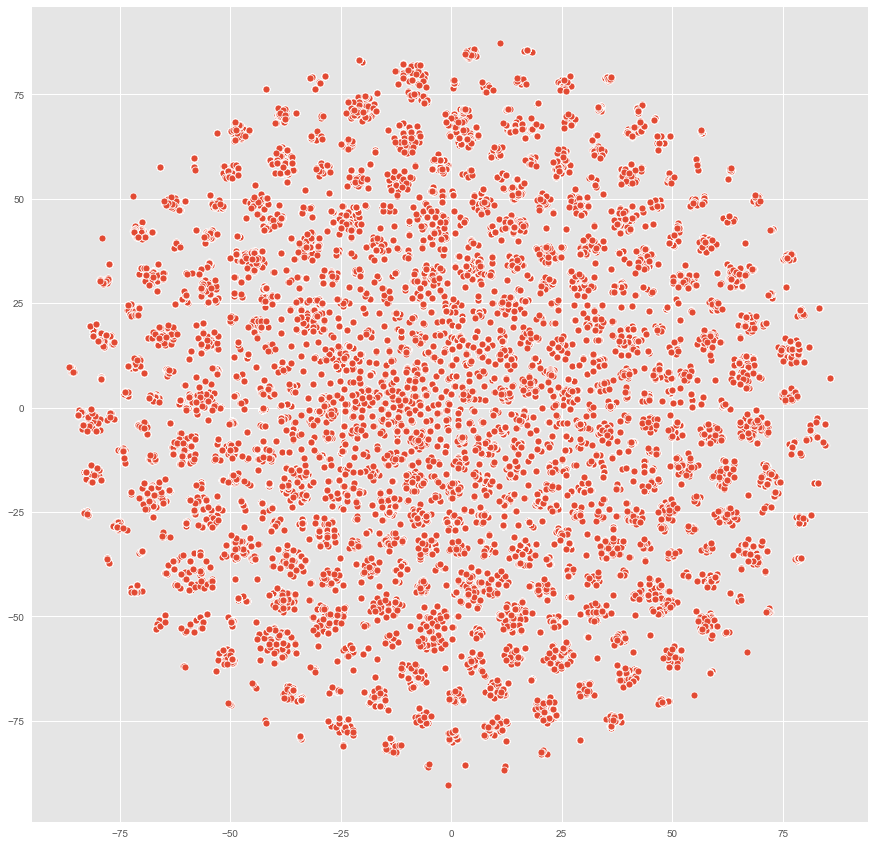

In [72]:
# code adopted from https://www.kaggle.com/nikitagrec/house-prices-clustering/execution

from sklearn.manifold import TSNE
tsn = TSNE(random_state=20)
res_tsne = tsn.fit_transform(X_hdn_scl)
plt.figure(figsize=(15,15))
sns.scatterplot(res_tsne[:,0],res_tsne[:,1]);

<span style="color:blue">

##### Filling in SALEPRICE

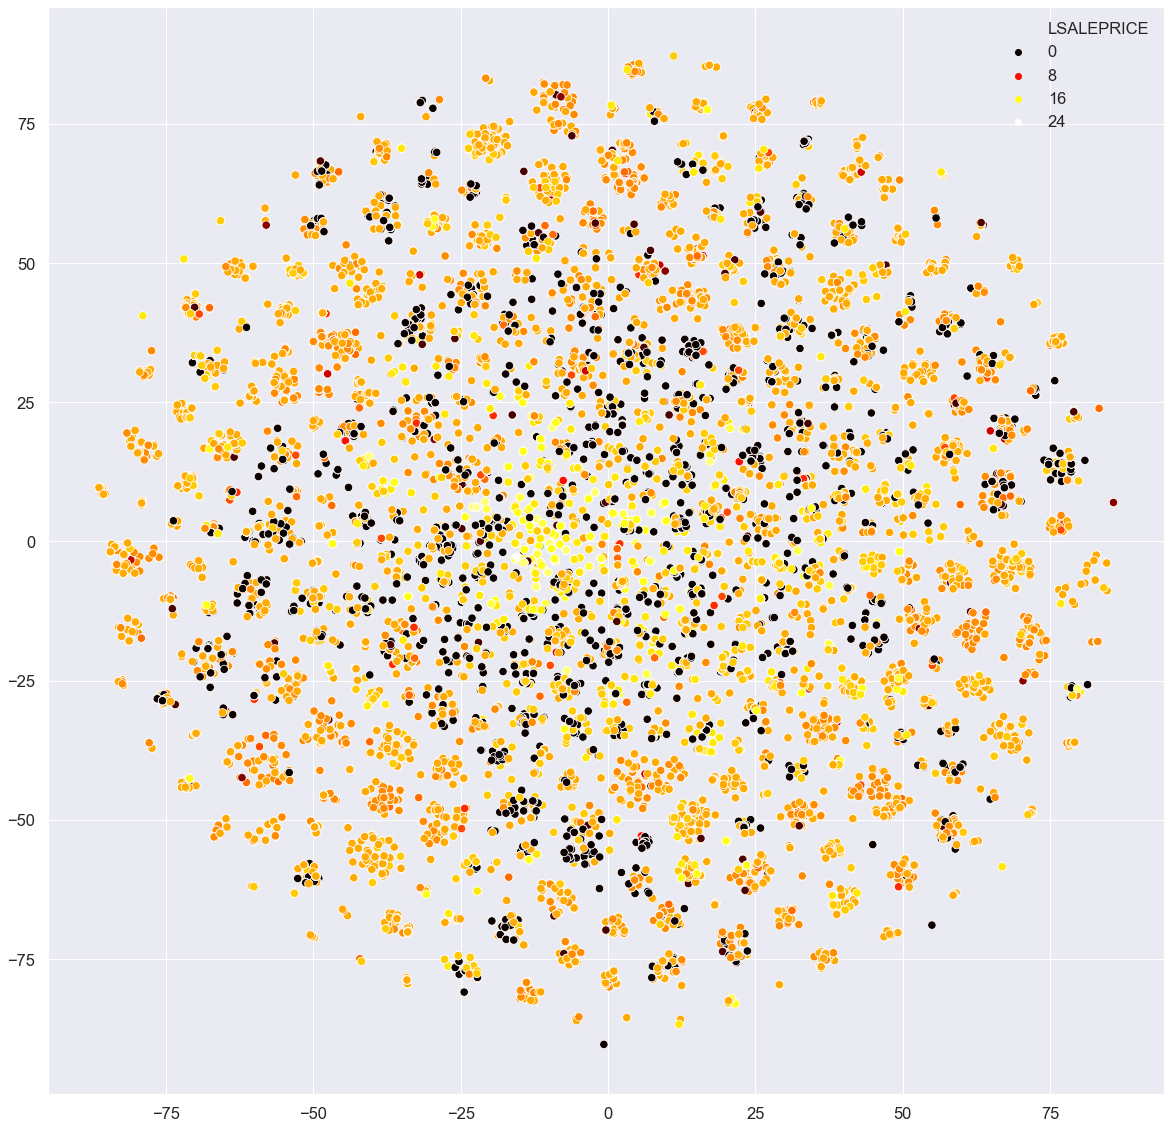

In [73]:
# code adopted from https://www.kaggle.com/nikitagrec/house-prices-clustering/execution
#Fill in SALEPRICE 

plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],\
                     hue=housing_data_num['LSALEPRICE'], s=70, palette="hot");#,palette="RdBu");

<span style="color:blue">

## Examination of TruncatedSVD on Numeric Data

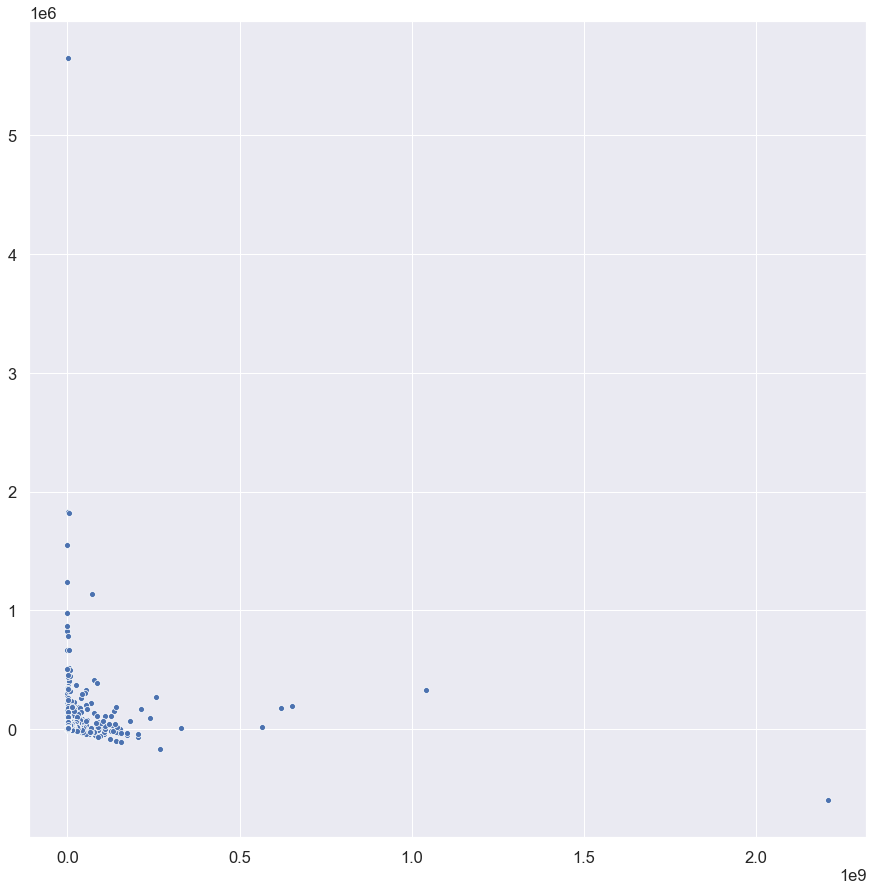

In [114]:
# code adopted from https://www.kaggle.com/nikitagrec/house-prices-clustering/execution
#Truncated SVD for dimensionality reduction (works better on sparce data where as PCA works better on dense data)
from sklearn.decomposition import TruncatedSVD

X = X_hdn

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=949)
X_SVD_reduced = svd.fit_transform(X)

#Plot to see if there are any self-evident clusters
plt.figure(figsize=(15,15))
sns.scatterplot(X_SVD_reduced[:,0],X_SVD_reduced[:,1]);

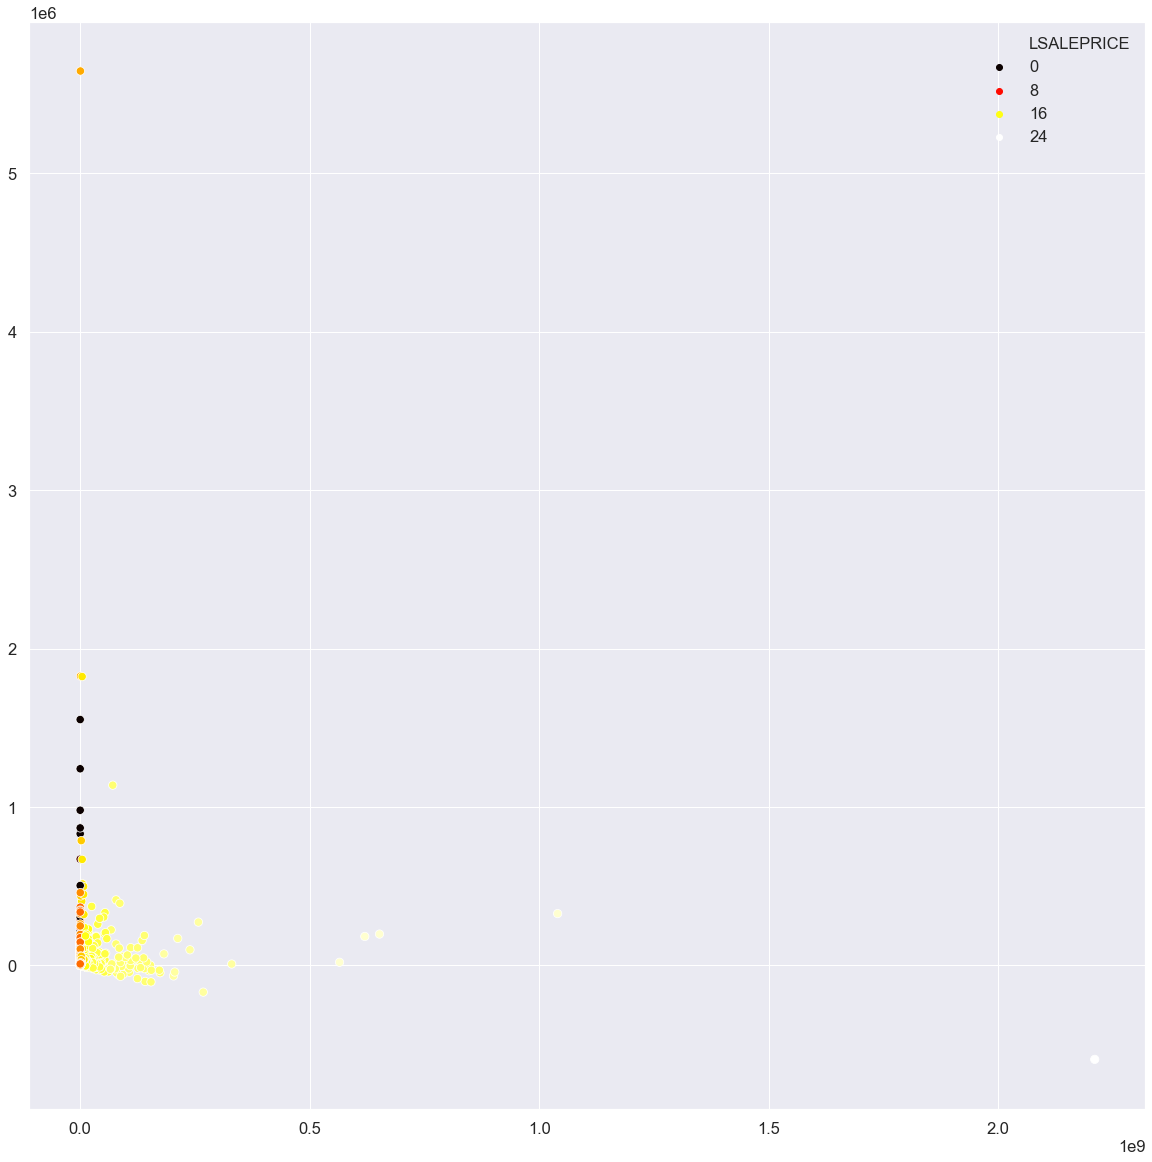

In [115]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
sns.scatterplot(x=X_SVD_reduced[:,0],y=X_SVD_reduced[:,1],\
                     hue=housing_data_num['LSALEPRICE'], s=70, palette="hot");#,palette="RdBu");

In [116]:
#Loop through clusters

#Test out the capped linear regression
#Loop through some cluster values to see if we move in the right direction
from sklearn.cluster import AgglomerativeClustering

agg_results = []

X1 = X_SVD_reduced

for i in range(4, 11):
    agg = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage='ward')
    agg.fit(X1)
    newfeature = agg.labels_ # the labels from kmeans clustering

    y = y_hdn
    X = X_regr_scl
    X = np.column_stack((X, pd.get_dummies(newfeature)))


    regr = CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1,
                       normalize=False)



    cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

    MAE = cross_val_score(regr,X,y=y,cv=cv, scoring = 'neg_mean_absolute_error')
    results = {"n_clusters": i, 'MAE': abs(MAE.mean())}
    agg_results.append(results)
    #print (i, "Clusters Average MAE = ", abs(MAE.mean()))

agg_results_df = pd.DataFrame.from_dict(agg_results)
agg_results_df

n_clusters           MAE
0           4  1.758050e+06
1           5  1.541675e+06
2           6  1.541675e+06
3           7  1.812144e+06
4           8  1.866238e+06
5           9  1.785097e+06
6          10  1.758050e+06

Visualizatoin of clusters with 5 clusters (tied for lowest MAE)

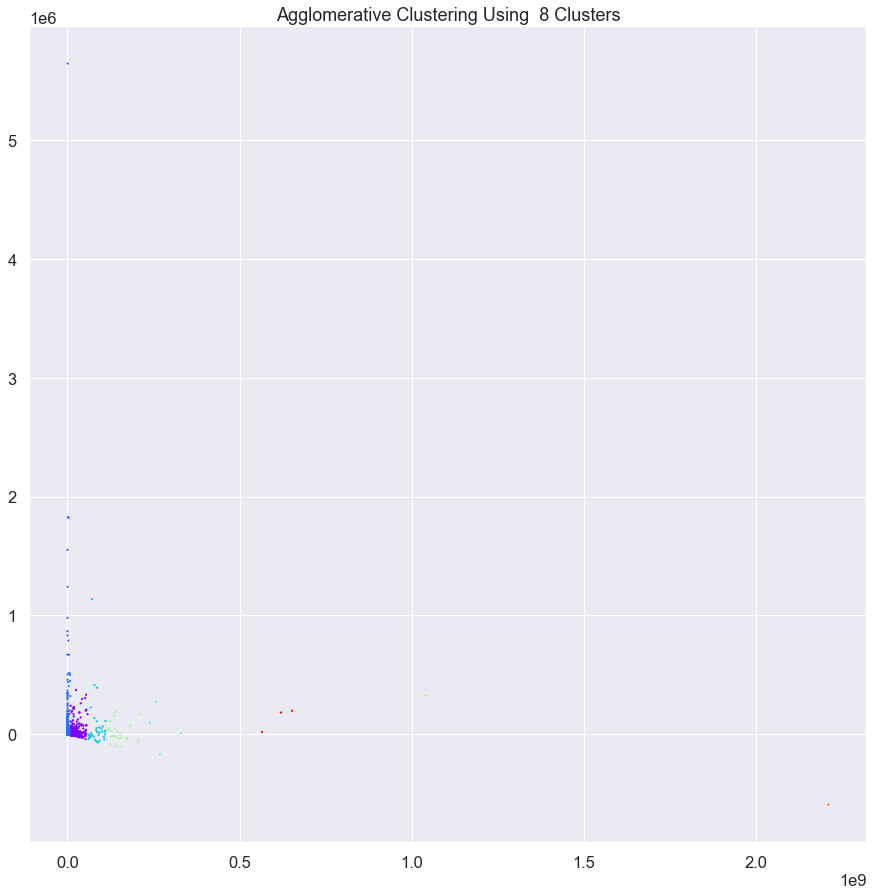

In [117]:
X1 = X_SVD_reduced
nclust = 8

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage='ward')
labels = spc.fit_predict(X1)

plt.figure(figsize=(15, 15))
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)
plt.title('Agglomerative Clustering Using  %d Clusters' % nclust)
plt.show()

<span style="color:blue">

## Examination of PCA on Numeric Data

In [74]:
#This function will plot PCs based on the length of features in the dataframe or change to how many features you wish to input 
def plot_pca(X,var_ratio_pcs = 60):
    # Perform PCA on the data to reduce the number of initial features 
    # and to remove correlations that are common between pixel features 
    pca = PCA(n_components=X.shape[1])
    pca.fit(X)

    # Inspect the explained variances to determine how many components to use  
    plt.subplots(figsize=(8, 8))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    print('Cumulative Explained variance explained with :', var_ratio_pcs , 'components:',sum(pca.explained_variance_ratio_[0:var_ratio_pcs]) )


In [108]:
y_hdn_pca = housing_data_num['LSALEPRICE'].values
X_hdn_pca = housing_data_num.drop(columns = ['LSALEPRICE','SALEPRICE'], axis = 1).values

In [109]:
ML_std_scalr.fit(X_hdn_pca)

X_pca_scl = ML_std_scalr.transform(X_hdn_pca)

Cumulative Explained variance explained with : 3 components: 0.6023224628493882


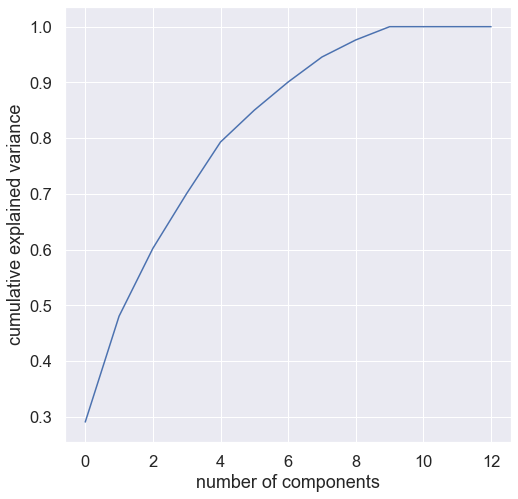

In [110]:
plot_pca(X_pca_scl, var_ratio_pcs = 3)

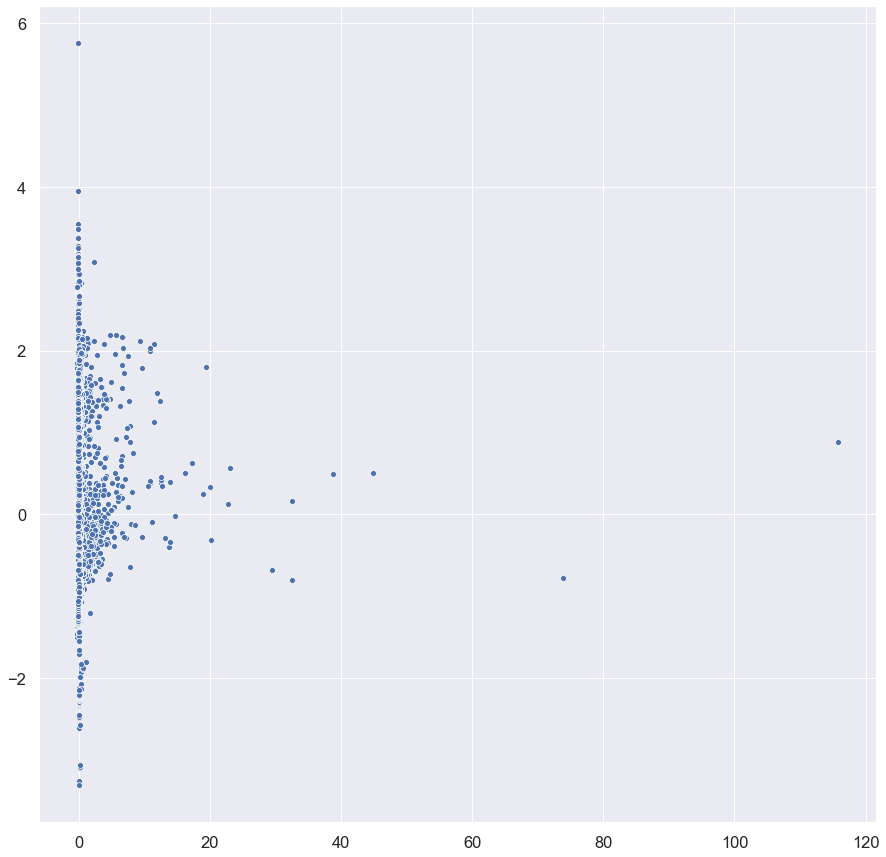

In [107]:
X1=X_pca_scl
pca = PCA(n_components=2, whiten=True).fit(X1)
X_pca = pca.transform(X1) #regular PCA

plt.figure(figsize=(15,15))
sns.scatterplot(X_pca[:,0],X_pca[:,1]);

Fill in LSALEPRICE to see if there are any visual clusters and an approximation of how many there might be. 

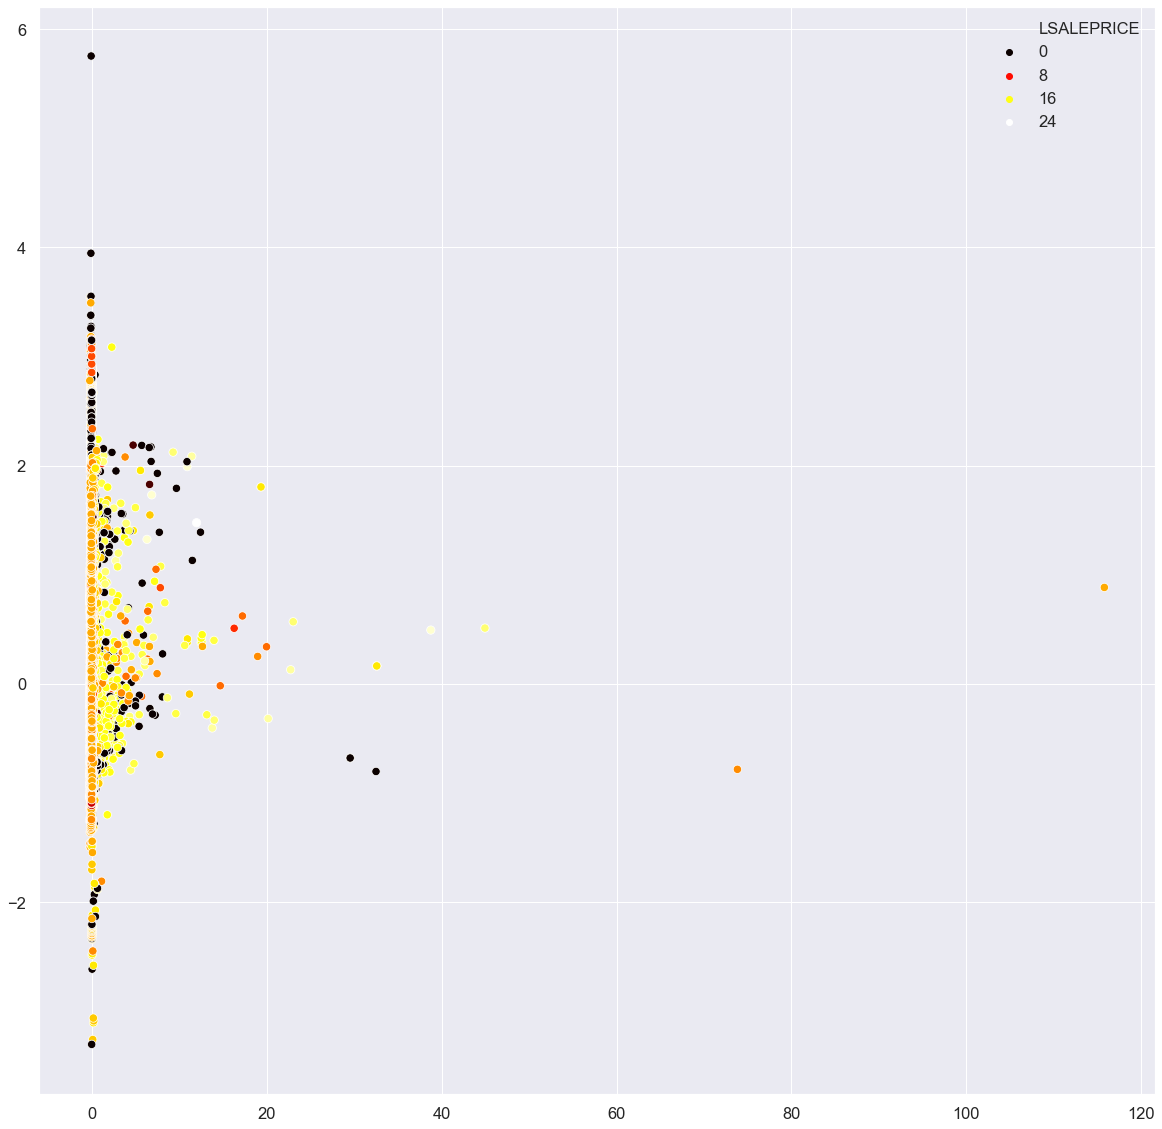

In [111]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
sns.scatterplot(x=X_pca[:,0],y=X_pca[:,1],\
                     hue=housing_data_num['LSALEPRICE'], s=70, palette="hot");#,palette="RdBu");

In [112]:
#Loop through clusters

#Test out the capped linear regression
#Loop through some cluster values to see if we move in the right direction
from sklearn.cluster import AgglomerativeClustering

agg_results = []

X1 = X_pca

for i in range(4, 11):
    agg = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage='ward')
    agg.fit(X1)
    newfeature = agg.labels_ # the labels from kmeans clustering

    y = y_hdn
    X = X_regr_scl
    X = np.column_stack((X, pd.get_dummies(newfeature)))


    regr = CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1,
                       normalize=False)



    cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

    MAE = cross_val_score(regr,X,y=y,cv=cv, scoring = 'neg_mean_absolute_error')
    results = {"n_clusters": i, 'MAE': abs(MAE.mean())}
    agg_results.append(results)
    #print (i, "Clusters Average MAE = ", abs(MAE.mean()))

agg_results_df = pd.DataFrame.from_dict(agg_results)
agg_results_df

n_clusters           MAE
0           4  1.622816e+06
1           5  1.920332e+06
2           6  1.758050e+06
3           7  1.758050e+06
4           8  1.568722e+06
5           9  1.703957e+06
6          10  1.406441e+06

In [145]:
X1 = X_pca

cls = AgglomerativeClustering(n_clusters=8, affinity = 'euclidean', linkage='ward')
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_hdn
X = X_regr_scl
X = np.column_stack((X,pd.get_dummies(newfeature)))

#ML_std_scalr.fit(X)

#X_scl = ML_std_scalr.transform(X)


regr = CappedLogLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)



cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

MAE = cross_val_score(regr,X,y=y,cv=cv, scoring = 'neg_mean_absolute_error')

print ("Average MAE = ", abs(MAE.mean()))

Average MAE =  3.6422558614665235


##### Cluster Visualization

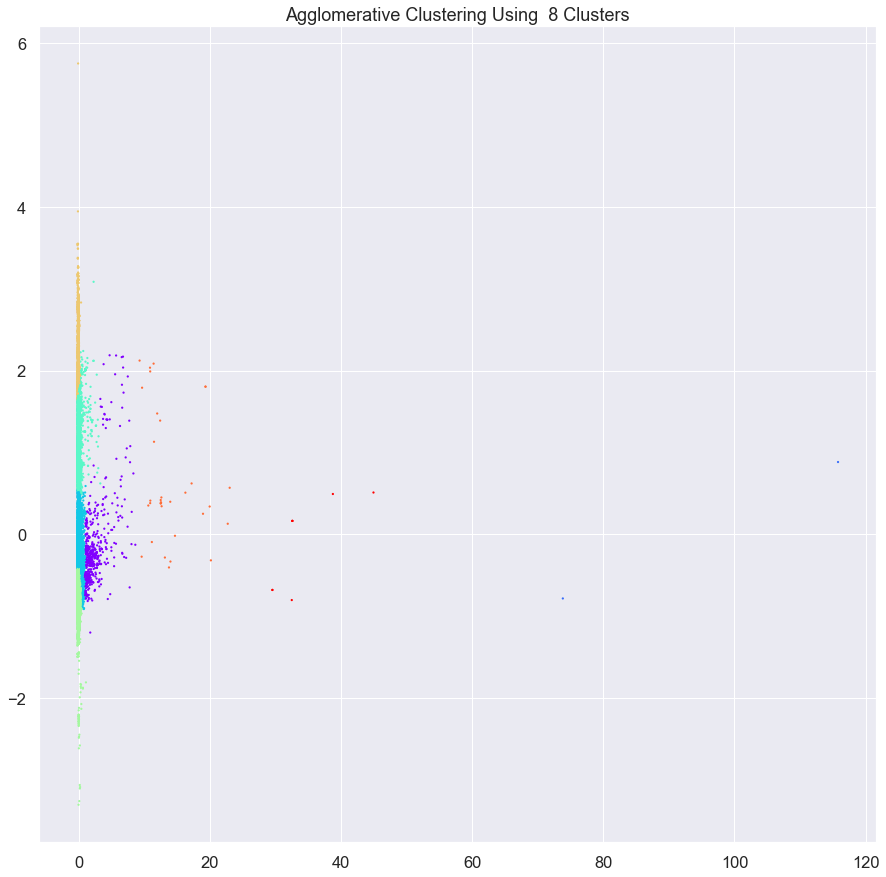

In [113]:
X1 = X_pca
nclust = 8

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage='ward')
labels = spc.fit_predict(X1)

plt.figure(figsize=(15, 15))
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)
plt.title('Agglomerative Clustering Using  %d Clusters' % nclust)
plt.show()

<span style="color:blue">

## Density-Basted Clustering

<span>

<span style="color:red">
    
# Commented out DBSCAN

#Code adopted from http://localhost:8890/notebooks/ICA4_DataMining_Submit%20(1).ipynb

# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
res_tsne_N = 30

#=======================================================

# create connectivity graphs before calcualting the hierarchy
res_tsne_N_knn_graph = kneighbors_graph(res_tsne, res_tsne_N, mode='distance') # calculate distance to four nearest neighbors 

N2 = res_tsne_N_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = res_tsne_N_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: res_tsne, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(res_tsne_N))
plt.grid(b=True, which='both', axis='y')

plt.show()

<span style="color:red">
    
# Commented out DBSCAN

#Code adopted from http://localhost:8890/notebooks/ICA4_DataMining_Submit%20(1).ipynb

from sklearn.cluster import DBSCAN
X2= res_tsne
X3 = res_tsne
#=====================================
# ENTER YOUR CODE HERE TO CHANGE MINPTS AND EPS FOR EACH DATASET
X2_minpts = 4 # from above
X2_eps = 1
X3_minpts = 30 # from above
X3_eps = 2
#=====================================

for i, (data, minpts, eps) in enumerate(zip([X2,X3],[X2_minpts,X3_minpts],[X2_eps,X3_eps])):

    db = DBSCAN(eps=eps, min_samples=minpts).fit(data)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # mark the samples that are considered "core"
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=(15,15))
    unique_labels = set(labels) # the unique labels
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        # plot the core points in this class
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=6)

        # plot the remaining points that are edge points
        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.grid()
    plt.show()

<span style="color:blue">
    
### Agglomerative Clustering for TSNE

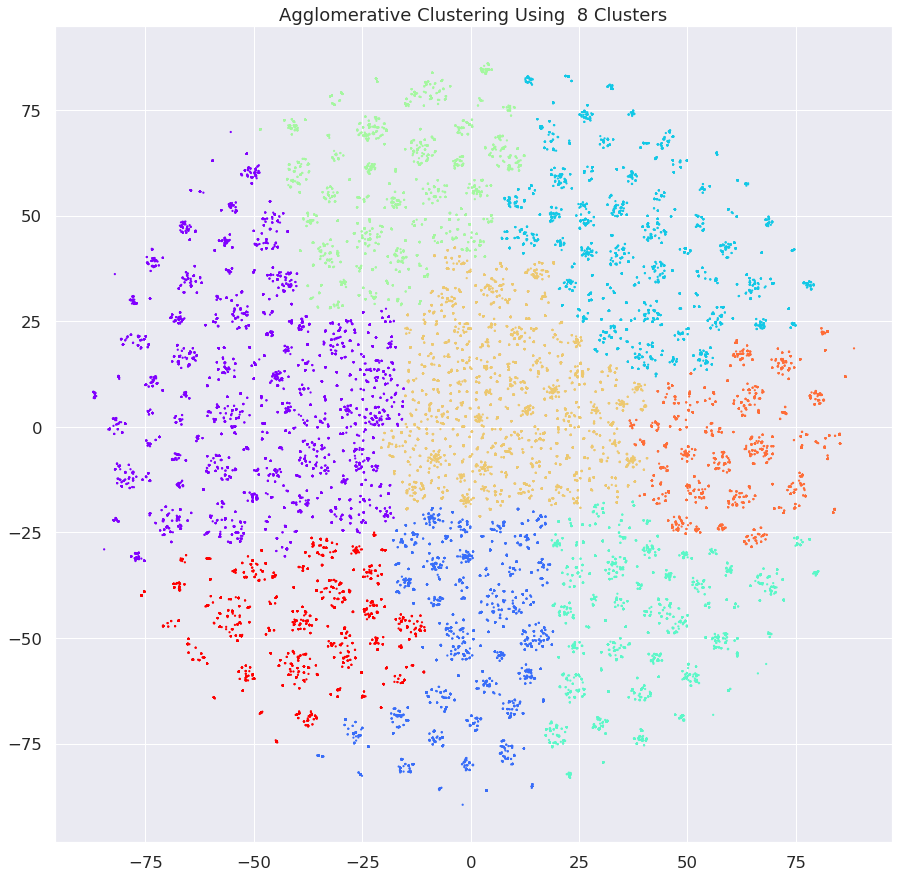

In [79]:
# code adopted from https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

X = res_tsne
nclust = 8

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage='ward')
labels = spc.fit_predict(X)

plt.figure(figsize=(15, 15))
plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)
plt.title('Agglomerative Clustering Using  %d Clusters' % nclust)
plt.show()

# Models 


Recall the dynamic range of the original data is between 0e0 to 2.2e9. For the regression task of this data we will use LSALEPRICE, as the target variable. Recall this is a log base 10 transformation of the SALEPRICE target variable, except where the 0s for sale price, the value has been changed to a 1, and then the log is taken. We took this approach since it is difficult to a sale price for these types of properties, since according to the data ontology, these are property transfers that occured outside of a traditional sale. Also, by taking the log of 1, this will compute to a zero value. This has scaled our values such that we can eliminate the large dynamic range of the target variable. 

We want to predict the LSALEPRICE for a property within a borough, for this task we will use MAE, since we are dealing with log scales, we can back transform the MAE to obtain the original scale or intrepret the results on a scaleless MAE and intrepret the multiplicative properties. In any event, the lower the MAE the better. For this reason we will use a capped linear regression as a baseline model, where the predictions will be "cut" to predict between (0e0, 2.1e1). 

In addition to the capped model, we are using two additional models, a Lasso regression and a gradient boosted regression model, as both models have parameters to allow us to penalize the model's L1 norm in the case of the Lasso regression for the sparcity of the encoded features and in the case of the GradientBoosting Regressor we can choose the number of stem and leaf nodes as well as whether the loss function is least squares or least absolute deviation, where the median of the predicted value is used. We also wanted to adjust the learning rates for the GradientBoosting Regressor in a reasonable amount of time given that we are doing 10 fold shuffle split cross validation. All three models were constructed and tested using 10 fold shuffle split cross validation, where all features were scaled and then followed by a grid search for the optimal hyper parameters.


#### Capped Linear Regression

This specific model caps the dynamic range of the predictions to our data set's target range of (0e0, 2.1e1) on scaled data followed by a grid search of optimal hyper parameters using a 10 fold 80/20 train test shuffle split. The only 2 parameters we are really adjusting for the capped linear regression is whether to normalize the features during fitting and whether to fit an intercept.

In [ ]:
#Create scaler object 
ML_std_scalr = StandardScaler()

In [ ]:

#Create a Linear Regression object and perform a grid search to find the best parameters
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

ML_std_scalr.fit(X_regr)

X_regr_scl = ML_std_scalr.transform(X_regr)


linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl,y_regr)

In [ ]:

#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

regGridSearch.best_estimator_

In [ ]:

#Create CappedLinearRegression predictions between 1e5 to 9.9e6 using the best parameters for our Linear Regression object
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

regEstimator = regGridSearch.best_estimator_

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
scoresResults_CappedReg =  EvaluateRegressionEstimator(regEstimator, X_regr_scl,y_regr, cv)

mae_avg_CappedLinearRegression = scoresResults_CappedReg['MAE'].mean()
scoresResults_CappedReg

###### Lasso Regression




https://scikit-learn.org/stable/modules/linear_model.html#lasso

A Lasso Regression on scaled data, using a grid parameter search and the 10 fold 80/20 train test shuffle split.

We are testing different alphas and selection paramters. From the documentation, alpha is controlling the degree of sparsity of the estimated coefficients from our selected features. We also wanted to test whether reusing the solution of the previous call to fit as initialization effected the results, which is why we tested the warm start parameter. Also, we tested whether the selection being set to ‘random’ where a random coefficient is updated every iteration rather than looping over features sequentially as the case with cyclic made a difference.

In [78]:

#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

ML_std_scalr.fit(X_regr)

X_regr_scl = ML_std_scalr.transform(X_regr)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl,y_regr)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  1.9min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [79]:
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='random', tol=0.0001, warm_start=True)

After using the outputs for the best parameters from the lasso regression and the 10 fold 80/20 train test shuffle split, the best average MAE produced is *** . A slight improvement over the capped linear regression model, it is worth pointing out, while this model uses the same capped data, this model does not have a fixed dynamic range for its predictions as in the case of the capped linear regression. And the fact that Lasso is penalizing for the number of parameters by use of Alpha = *** is encouraging to know Lasso could be used for the dynamic ranges outside of what we caped our data to.

In [81]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=0, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X_regr_scl,y_regr, cv)

mae_avg_Lasso = scoresResults_Lasso['MAE'].mean()
scoresResults_Lasso

C:\Users\seans\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\seans\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\seans\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\seans\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\seans\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\seans\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\seans\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\seans\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by z

The average MAE for all cv folds is: 			 3.7707
The average MAE percentage (MAPE) for all cv folds is: 	 26.652
The average RMSE for all cv folds is: 			 4.8448
*********************************************************
The average MSE for all cv folds is: 			 23.473
*********************************************************
The average score_time for all cv folds is: 			 0.036715
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\seans\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\seans\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide



MAE       MAPE      RMSE        MSE  SCORE_TIME
0  3.776390  26.555547  4.838028  23.406511    0.038738
1  3.756856  26.363319  4.839268  23.418517    0.036344
2  3.798980  27.005136  4.865192  23.670090    0.037809
3  3.745104  26.339255  4.812681  23.161900    0.037826
4  3.737436  27.390786  4.798378  23.024433    0.035840
5  3.760551  27.322342  4.836468  23.391425    0.036963
6  3.796184  25.820504  4.887953  23.892081    0.034778
7  3.749763  26.095365  4.834671  23.374045    0.036118
8  3.761713  25.698188  4.837625  23.402613    0.036877
9  3.823621  27.927537  4.898206  23.992425    0.035858

###### Gradient Boosting Regressor


https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting

A gradient boosing regressor on scaled data, using a grid search for optimal parameters and the 10 fold 80/20 train test shuffle split. From the documentation, the most important parameters are the learning rate and the n_estimators, when we adjust the learning rate we are accounting for overfitting via shrinkage, and by adjusting the n_estimators parameter we are controlling the number of weak learners or regression trees, we will be controlling the size of each tree by the max_depth parameter.

In [ ]:

#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

ML_std_scalr.fit(X_regr)


X_regr_scl = ML_std_scalr.transform(X_regr)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
linreg = GradientBoostingRegressor()

parameters = { 'loss' : ['ls', 'lad']
              ,'learning_rate' : [1e-3, 1e-1]
              ,'n_estimators': [100, 500] 
              ,'criterion': ['mae']
              ,'min_samples_split':[3,5]
              ,'min_samples_leaf': [10, 25]
              ,'max_leaf_nodes' : [25,40]
              ,'max_depth': [3,10]
              ,'max_features' : ['auto']
              ,'subsample' : [1e-2]
              ,'random_state': [0]
             }



              

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl , y_regr)

In [ ]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
#Display the best estimator parameters
regGridSearch.best_estimator_

After using the outputs for the best parameters from the gradient boosting regression and the 10 fold 80/20 train test shuffle split, the best average MAE produced is 3.70e5. While this model does not have a fixed dynamic range as in the case of the capped linear regression, we see it has a seemingly different average MAE as compared to the LASSO regression.

In [ ]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation
regEstimator = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_GradientBoostingRegressor = EvaluateRegressionEstimator(regEstimator, X_regr_scl , y_regr, cv)


mae_avg_GradientBoostingRegressor = scoresResults_GradientBoostingRegressor['MAE'].mean()
scoresResults_GradientBoostingRegressor

## Exceptional Work    -- added by Rajesh

#### LASSO ON IMPUTED DATA WITH ALL THE FIELDS

https://scikit-learn.org/stable/modules/linear_model.html#lasso

A Lasso Regression on scaled data, using a grid parameter search and the 10 fold 80/20 train test shuffle split.

We are testing different alphas and selection paramters. From the documentation, alpha is controlling the degree of sparsity of the estimated coefficients from our selected features. We also wanted to test whether reusing the solution of the previous call to fit as initialization effected the results, which is why we tested the warm start parameter. Also, we tested whether the selection being set to ‘random’ where a random coefficient is updated every iteration rather than looping over features sequentially as the case with cyclic made a difference.

In [537]:

#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

ML_std_scalr.fit(X_regr_impute)

X_regr_scl = ML_std_scalr.transform(X_regr_impute)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl,y_regr_impute)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  5.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [538]:
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=True)

After using the outputs for the best parameters from the lasso regression and the 10 fold 80/20 train test shuffle split, the best average MAE produced is *** . A slight improvement over the capped linear regression model, it is worth pointing out, while this model uses the same capped data, this model does not have a fixed dynamic range for its predictions as in the case of the capped linear regression. And the fact that Lasso is penalizing for the number of parameters by use of Alpha = *** is encouraging to know Lasso could be used for the dynamic ranges outside of what we caped our data to.

In [539]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=0, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X_regr_scl,y_regr_impute, cv)

mae_avg_Lasso = scoresResults_Lasso['MAE'].mean()
scoresResults_Lasso

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATR

The average MAE for all cv folds is: 			 0.84041
The median absolute error for all cv folds is: 			 0.36936
The average MAE percentage (MAPE) for all cv folds is: 	 12.768
The average RMSE for all cv folds is: 			 1.6904
*********************************************************
The average MSE for all cv folds is: 			 2.8589
*********************************************************
The average score_time for all cv folds is: 			 0.023848
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide



MAE       MED       MAPE      RMSE       MSE  SCORE_TIME
0  0.831671  0.372837  12.557471  1.654974  2.738937    0.036427
1  0.858942  0.367925  12.993234  1.730837  2.995797    0.023932
2  0.845924  0.366870  13.158558  1.695705  2.875414    0.020945
3  0.840000  0.370532  12.210741  1.678130  2.816119    0.021942
4  0.831422  0.373305  12.564966  1.663932  2.768671    0.018950
5  0.851605  0.368504  13.267010  1.744570  3.043525    0.019946
6  0.848090  0.368781  13.168546  1.714574  2.939765    0.021945
7  0.827659  0.369946  12.652763  1.675615  2.807687    0.024524
8  0.854234  0.368275  13.669715  1.735057  3.010423    0.020943
9  0.814535  0.376468  11.440927  1.610241  2.592875    0.028924

## KMEAN

<span style="color:blue">

#### 1. Loop through n_clusters to idnetify highest overall Silhouette score

We will be using Silhouette analysis to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

Based on Silhouette score, following are the top three clusters for ['COMMERCIALUNITS','BorZip'] out of all the combinations ran. We shall further plot top three n_cluster values to visually inspect for ['COMMERCIALUNITS','BorZip'] cluster



['COMMERCIALUNITS' 'BorZip']

Number of clusters =  11
Silhouette score =  0.9794471221553575

Number of clusters =  9
Silhouette score =  0.9785340412992206


['LLANDSQUAREFEET' 'BorZip']

Number of clusters =  19
Silhouette score =  0.9801108849061608






In [514]:
from sklearn.cluster import KMeans
from sklearn import metrics 



clusters = np.arange(7, 21, 2)

C=[]


X1 = X_scl_df_impute[['LGROSSSQUAREFEET', 'BorZip']]
X2 = X_scl_df_impute[['COMMERCIALUNITS', 'BorZip']]
X3 = X_scl_df_impute[['TOTALUNITS', 'BorZip']]
X4 = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X5 = X_scl_df_impute[['YEARBUILT', 'BorZip']]
X6 = X_scl_df_impute[['BUILDAGE', 'BorZip']]
X7 = X_scl_df_impute[['RES_COM_UNITS', 'BorZip']]
X8 = X_scl_df_impute[['RES_COM_UNITS', 'BUILDAGE']]
X9 = X_scl_df_impute[['RES_COM_UNITS', 'YEARBUILT']]

C.append(X1)
C.append(X2)
C.append(X3)
C.append(X4)
C.append(X5)
C.append(X6)
C.append(X7)
C.append(X8)
C.append(X9)

 
for x in C:
    
    print('----------------------------------')
    print(x.columns.values)
    print('----------------------------------')
    scores = []
    for i in clusters: 
        
        cls = KMeans(n_clusters=i, init='k-means++',random_state=1)
        cls.fit(x)
        score = metrics.silhouette_score(x, cls.labels_, metric = 'euclidean', sample_size = len(x)) 

        print('\nNumber of clusters = ', i)
        print('Silhouette score = ', score)

        #scores.append(score)
    
    
    #plt.figure()
    #plt.bar(clusters, scores, width=0.6, color='k', align='center')
    #plt.title('Silhouette score vs number of clusters')

# plt.figure()
# plt.scatter(X1[:,0], X1[:,1], color = 'k', s=30, marker = 'o', facecolors='none')
# x_min, x_max = min(X1[:,0]) - 1, max(X1[:,0]) + 1 
# y_min, y_max = min(X1[:,1]) - 1 , max(X1[:,1]) + 1 
# plt.title('Input Cluster')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

# plt.show()
  

----------------------------------
['LGROSSSQUAREFEET' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.8609838756919693

Number of clusters =  9
Silhouette score =  0.8759844794723338

Number of clusters =  11
Silhouette score =  0.8930330271296482

Number of clusters =  13
Silhouette score =  0.9263658945860602

Number of clusters =  15
Silhouette score =  0.9522159307497456

Number of clusters =  17
Silhouette score =  0.9592370794355057

Number of clusters =  19
Silhouette score =  0.9696190475414408
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.9696294058447249

Number of clusters =  9
Silhouette score =  0.9785340412992206

Number of clusters =  11
Silhouette score =  0.9794471221553575

Number of clusters =  13
Silhouette score =  0.9698642417497558

Number of clusters =  15
Silhouette score =  0.958106628054967

Number of clusters =  17


<span style="color:blue">

#### 2. Plot top three n_cluster values to visually inspect clusters

Automatically created module for IPython interactive environment
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------
For n_clusters = 9 The average silhouette_score is : 0.9785340412992066
For n_clusters = 11 The average silhouette_score is : 0.9794471221553332
----------------------------------
['LLANDSQUAREFEET' 'BorZip']
----------------------------------
For n_clusters = 19 The average silhouette_score is : 0.9823098325578916


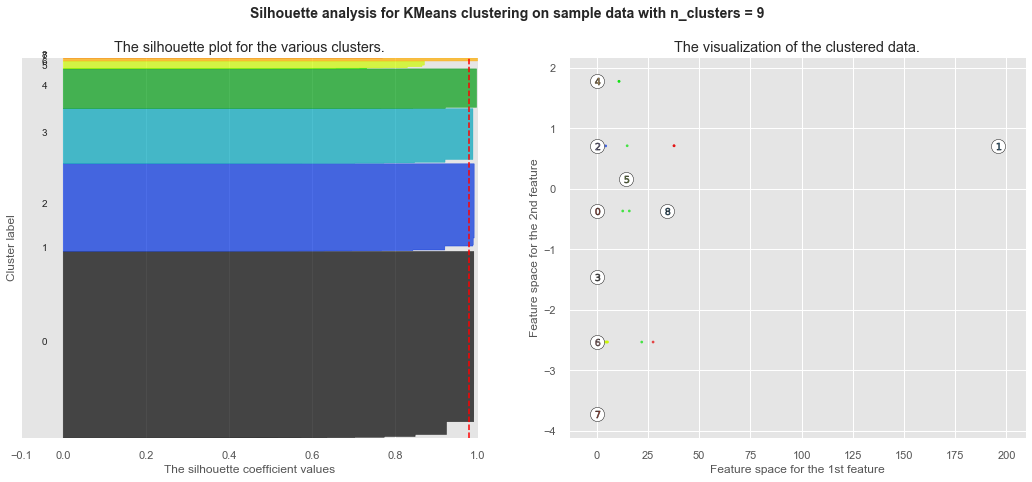

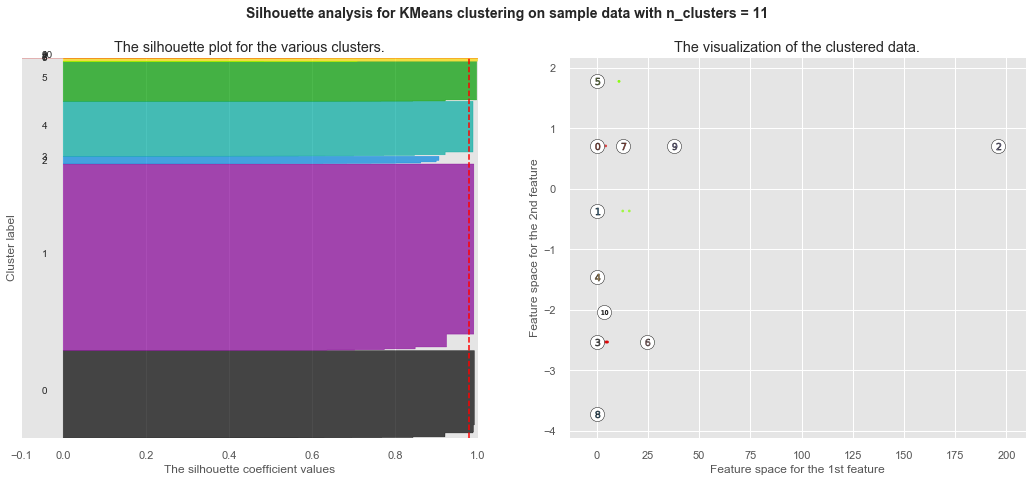

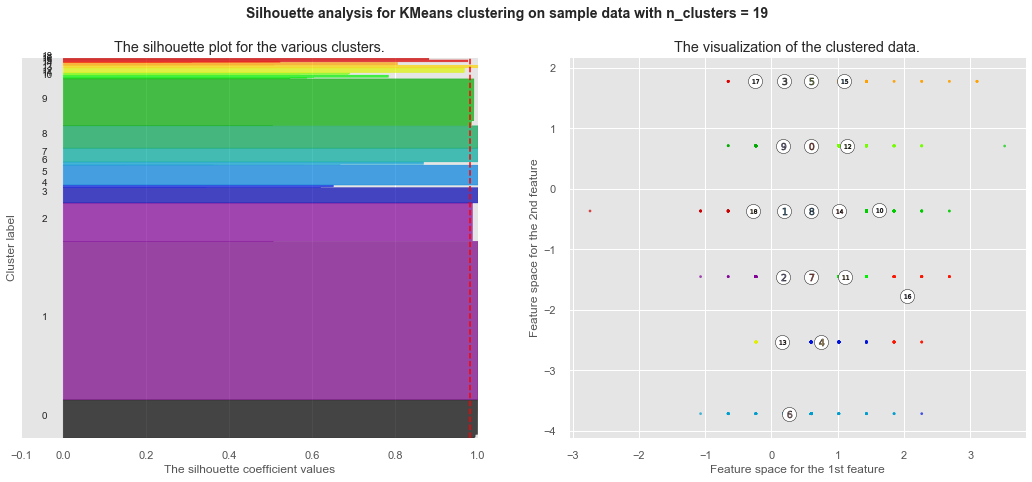

In [515]:

#Code adopted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


X = X_scl_df_impute[['COMMERCIALUNITS', 'BorZip']]

y = y_scl_impute

range_n_clusters = [9, 11]

print('----------------------------------')
print(X.columns.values)
print('----------------------------------')

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    
    
X1 = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]

range_n_clusters1 = [19]
    
    
print('----------------------------------')
print(X1.columns.values)
print('----------------------------------')

for n_clusters in range_n_clusters1:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X1) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X1, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X1.iloc[:, 0], X1.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

It appears that 19 clusters has the most viable clusters

<span style="color:blue">

#### 3. Test reduced dataset against regression model and compare to benchmark

Lasso Regression

In [519]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Recluster and stack cluster values onto dataset


X =  X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
y = y_scl_impute
X1 = ml_df_enc_regr_impute[['LLANDSQUAREFEET', 'BorZip']]

cls = KMeans(n_clusters=19, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl_impute
X = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

#Run clustered dataset through GridSearch and regression

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X,y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.9s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   24.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [520]:
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=True)

In [521]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=959, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X, y, cv)

mae_avg_Lasso = scoresResults_Lasso['MAE'].mean()
scoresResults_Lasso

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATR

The average MAE for all cv folds is: 			 0.87407
The median absolute error for all cv folds is: 			 0.32963
The average MAE percentage (MAPE) for all cv folds is: 	 13.031
The average RMSE for all cv folds is: 			 1.716
*********************************************************
The average MSE for all cv folds is: 			 2.9461
*********************************************************
The average score_time for all cv folds is: 			 0.0039979
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide



MAE       MED       MAPE      RMSE       MSE  SCORE_TIME
0  0.865061  0.331237  12.806537  1.679306  2.820067    0.003994
1  0.892093  0.323820  13.259693  1.756465  3.085169    0.002992
2  0.881170  0.331328  13.444208  1.725262  2.976528    0.004984
3  0.875109  0.330838  12.482882  1.704820  2.906410    0.004452
4  0.862621  0.329613  12.805296  1.688584  2.851315    0.002992
5  0.884760  0.322905  13.519006  1.766784  3.121526    0.003210
6  0.883352  0.329655  13.442908  1.739813  3.026950    0.005263
7  0.861381  0.327010  12.915651  1.701644  2.895593    0.003500
8  0.889119  0.327527  13.933737  1.760310  3.098691    0.005435
9  0.846013  0.333175  11.695364  1.636754  2.678965    0.003156

Baseline LASSO: The median absolute error for all cv folds is: 0.36936

KMeans, n_clusters=19
The median absolute error for all cv folds is:0.32478

## Agglomerative Cluster

<span style="color:blue">

#### 1. Loop through n_clusters to idnetify highest overall Silhouette score

Based on Silhouette score, following are the top three clusters out of all the combinations ran. We shall further plot top three n_cluster values to visually inspect.

['LLANDSQUAREFEET' 'BorZip']

Number of clusters =  19
Silhouette score =  0.9817179593496566

['COMMERCIALUNITS' 'BorZip']

Number of clusters =  13
Silhouette score =  0.9800971987429561

['LGROSSSQUAREFEET' 'BorZip']

Number of clusters =  19
Silhouette score =  0.9795500477122053

In [522]:
from sklearn.cluster import KMeans
from sklearn import metrics 



clusters = np.arange(7, 21, 2)

C=[]


X1 = X_scl_df_impute[['LGROSSSQUAREFEET', 'BorZip']]
X2 = X_scl_df_impute[['COMMERCIALUNITS', 'BorZip']]
X3 = X_scl_df_impute[['TOTALUNITS', 'BorZip']]
X4 = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X5 = X_scl_df_impute[['YEARBUILT', 'BorZip']]
X6 = X_scl_df_impute[['BUILDAGE', 'BorZip']]
X7 = X_scl_df_impute[['RES_COM_UNITS', 'BorZip']]
X8 = X_scl_df_impute[['RES_COM_UNITS', 'BUILDAGE']]
X9 = X_scl_df_impute[['RES_COM_UNITS', 'YEARBUILT']]

C.append(X1)
C.append(X2)
C.append(X3)
C.append(X4)
C.append(X5)
C.append(X6)
C.append(X7)
C.append(X8)
C.append(X9)

 
for x in C:
    
    print('----------------------------------')
    print(x.columns.values)
    print('----------------------------------')
    scores = []
    for i in clusters: 
        
        cls = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage='ward')
        cls.fit(x)
        score = metrics.silhouette_score(x, cls.labels_, metric = 'euclidean', sample_size = len(x)) 

        print('\nNumber of clusters = ', i)
        print('Silhouette score = ', score)

        #scores.append(score)
    
    
    #plt.figure()
    #plt.bar(clusters, scores, width=0.6, color='k', align='center')
    #plt.title('Silhouette score vs number of clusters')

# plt.figure()
# plt.scatter(X1[:,0], X1[:,1], color = 'k', s=30, marker = 'o', facecolors='none')
# x_min, x_max = min(X1[:,0]) - 1, max(X1[:,0]) + 1 
# y_min, y_max = min(X1[:,1]) - 1 , max(X1[:,1]) + 1 
# plt.title('Input Cluster')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

# plt.show()
  


----------------------------------
['LGROSSSQUAREFEET' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.8606263241315335

Number of clusters =  9
Silhouette score =  0.8756442521154689

Number of clusters =  11
Silhouette score =  0.9170427832087272

Number of clusters =  13
Silhouette score =  0.9280028766440369

Number of clusters =  15
Silhouette score =  0.9530782800798427

Number of clusters =  17
Silhouette score =  0.9678371356034159

Number of clusters =  19
Silhouette score =  0.9795500477122053
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.9693774051507796

Number of clusters =  9
Silhouette score =  0.9779178531803184

Number of clusters =  11
Silhouette score =  0.9786655645411559

Number of clusters =  13
Silhouette score =  0.9800971987429561

Number of clusters =  15
Silhouette score =  0.9703512548648187

Number of clusters =  17

<span style="color:blue">

#### 2. Plot top three n_cluster values to visually inspect clusters

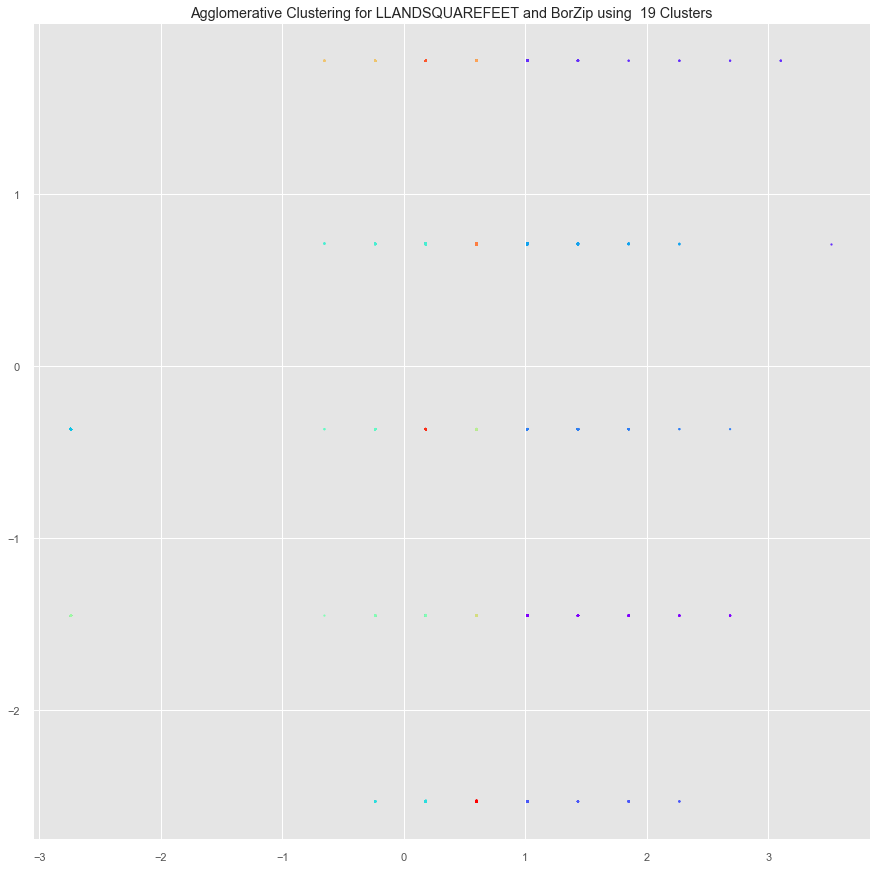

In [529]:

X1 = X_scl_df[['LLANDSQUAREFEET', 'BorZip']].values
nclust = 19

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage='ward')
labels = spc.fit_predict(X1)

plt.figure(figsize=(15, 15))
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)
plt.title('Agglomerative Clustering for LLANDSQUAREFEET and BorZip using  %d Clusters' % nclust)
plt.show()

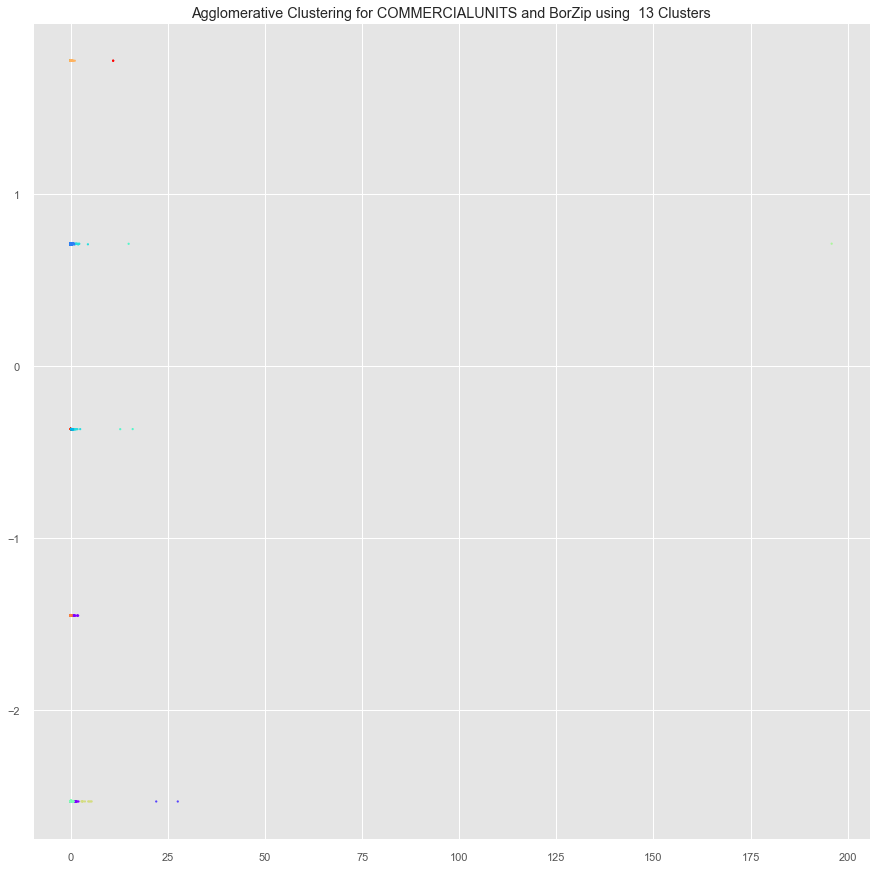

In [530]:
X1 = X_scl_df[['COMMERCIALUNITS', 'BorZip']].values
nclust = 13

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage='ward')
labels = spc.fit_predict(X1)

plt.figure(figsize=(15, 15))
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)
plt.title('Agglomerative Clustering for COMMERCIALUNITS and BorZip using  %d Clusters' % nclust)
plt.show()

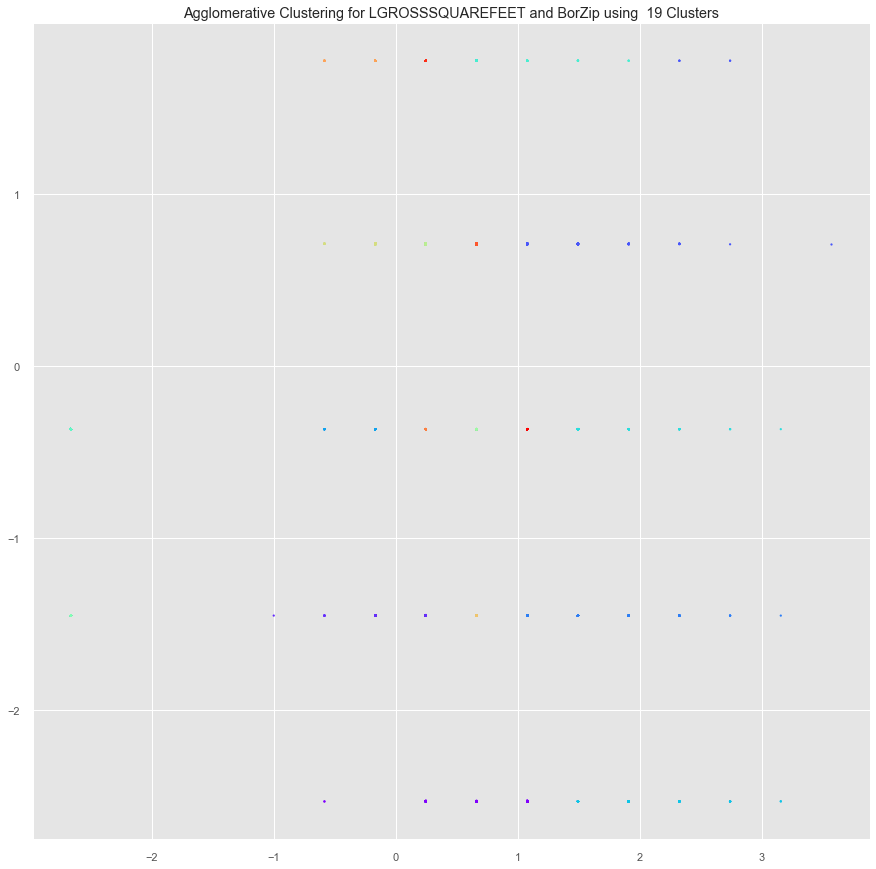

In [525]:
X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']].values
nclust = 19

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage='ward')
labels = spc.fit_predict(X1)

plt.figure(figsize=(15, 15))
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)
plt.title('Agglomerative Clustering for LGROSSSQUAREFEET and BorZip using  %d Clusters' % nclust)
plt.show()


<span style="color:blue">

#### 3. Test reduced dataset against regression model and compare to benchmark

Lasso Regression

In [526]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Recluster and stack cluster values onto dataset


X =  X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
y = y_scl_impute
X1 = ml_df_enc_regr_impute[['LLANDSQUAREFEET', 'BorZip']]

cls = AgglomerativeClustering(n_clusters=19, affinity = 'euclidean', linkage='ward')
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl_impute
X = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

#Run clustered dataset through GridSearch and regression

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X,y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   21.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   21.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [527]:
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=True)

In [528]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=959, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X, y, cv)

mae_avg_Lasso = scoresResults_Lasso['MAE'].mean()
scoresResults_Lasso

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATRK001\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\SATR

The average MAE for all cv folds is: 			 0.874
The median absolute error for all cv folds is: 			 0.32977
The average MAE percentage (MAPE) for all cv folds is: 	 13.03
The average RMSE for all cv folds is: 			 1.7158
*********************************************************
The average MSE for all cv folds is: 			 2.9454
*********************************************************
The average score_time for all cv folds is: 			 0.0044868
*********************************************************
Cross Validation Fold Mean Error Scores


MAE       MED       MAPE      RMSE       MSE  SCORE_TIME
0  0.864893  0.331276  12.805441  1.678987  2.818996    0.011968
1  0.892109  0.324118  13.259924  1.756368  3.084829    0.003989
2  0.881167  0.331617  13.444323  1.725125  2.976056    0.003990
3  0.875097  0.331134  12.482953  1.704675  2.905918    0.004974
4  0.862473  0.329751  12.804369  1.688300  2.850356    0.003991
5  0.884716  0.323159  13.518819  1.766614  3.120925    0.003990
6  0.883199  0.329793  13.441963  1.739536  3.025985    0.001992
7  0.861392  0.327308  12.915712  1.701481  2.895037    0.002992
8  0.889056  0.327868  13.933581  1.760035  3.097723    0.003991
9  0.845872  0.333287  11.694512  1.636452  2.677974    0.002992

Baseline LASSO: The median absolute error for all cv folds is: 0.36936

Agglomerative, n_clusters=19 

The median absolute error for all cv folds is:0.32977